In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib.colors import LogNorm
from scipy.integrate import simps
from time import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})

In [3]:
from matplotlib.colors import LogNorm, SymLogNorm

In [4]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats

In [6]:
data = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')


In [7]:
# states = data['LocationDesc'].unique()
statesid = data['LocationAbbr'].unique()
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']


controlstates = []


ils, sil = {}, {}
for i in range(len(statesid)):
    ils[i] = statesid[i]
    sil[statesid[i]] = i
    if statesid[i] in sskip: continue
    else: controlstates.append(statesid[i])
        
    

In [8]:
data['SubMeasureDesc'].unique();

In [9]:
sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']

# Setup

In [10]:
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')

nyears = years.size
i1 = 18
yearspred =  years[i1:]
yy = years.size


In [11]:
statesales = {}
statecosts = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')
    loc = costs['LocationAbbr'] == s
    statecosts[s] = costs[loc]['Data_Value'].values.astype('float32')
# ss = 'CO'
# tmp = statesales['CA'].copy()
# statesales['CA'] = statesales[ss].copy()
# statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    salearray[i] = statesales[ils[i]]
    
costarray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    costarray[i] = statecosts[ils[i]]
    
# salearrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: salearrayca.append(statesales[ils[i]])
# salearrayca = np.array(salearrayca)

salearrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: salearrayskip.append(statesales[ils[i]])
salearrayskip = np.array(salearrayskip)
salearrayca = salearrayskip

# costarrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: costarrayca.append(statecosts[ils[i]])
# costarrayca = np.array(costarrayca)
costarrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: costarrayskip.append(statecosts[ils[i]])
costarrayskip = np.array(costarrayskip)
costarrayca = costarrayskip

casales = statesales['CA']
meansales = salearrayca.mean(axis=0)

meansalesca = salearrayca.mean(axis=0)
stdsalesca = salearrayca.std(axis=0)
meansalesskip = salearrayskip.mean(axis=0)
cacosts = statecosts['CA']
meancosts = costarrayca.mean(axis=0)
meancostsskip = costarrayskip.mean(axis=0)


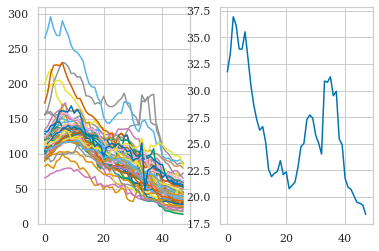

In [12]:
plt.subplot(121)
plt.plot(salearray.T)
plt.subplot(122)
plt.plot(salearray.std(axis=0))


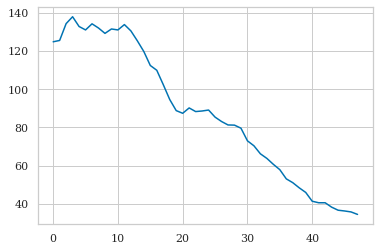

In [13]:
plt.plot(salearray[5])


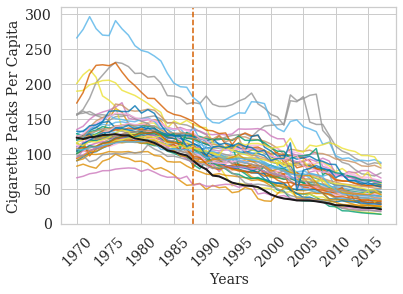

In [14]:
plt.plot(salearray.T, alpha=0.8)
plt.ylabel('Cigarette Packs Per Capita', fontsize=14)
plt.xlabel('Years', fontsize=14)
axis = plt.gca()
axis.set_xticks(np.arange(years.size)[::5])
axis.set_xticklabels(years[::5].astype(int))
matplotlib.pyplot.sca(axis)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.plot(salearray[4], color='k', lw=2)
plt.axvline(18, color='r', ls="--")
plt.show()


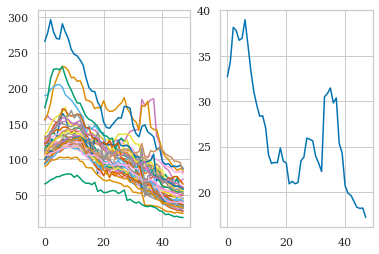

In [15]:
plt.subplot(121)
plt.plot(salearrayskip.T)
plt.subplot(122)
plt.plot(salearrayskip.std(axis=0))


# Functions

In [16]:
def psfunc(x, x2=None, real=True, ortho=True):

    if ortho: norm='ortho'
    else: norm=None
    if x2 is None: x2 = x.copy()
    if real: 
        xc, xc2 = np.fft.rfft(x, norm=norm), np.fft.rfft(x2, norm=norm)
    else:
        xc, xc2 = np.fft.fft(x, norm=norm), np.fft.fft(x2, norm=norm)
    ps = (xc * xc2.conj()).real
    return ps

def DFT(x, real=False, matrix=False, ortho=True, inv=False):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    Minv = M.conj().T/N
    if ortho: 
        M /= np.sqrt(N)
        Minv *= np.sqrt(N)
    if matrix: 
        if inv: return Minv
        else: return M
    fft = np.dot(M, x)
    if real: fft = fft[:N//2+1]
    return fft

## Check Parsevals theorem here

white = np.random.normal(0, 5, 10000)
print(white.std()**2)
# whitec = np.fft.rfft(white, norm='ortho')

whitepk = psfunc(white, ortho=True)
ffc = np.fft.rfftfreq(white.size)
print((np.trapz(whitepk, ffc)), (np.trapz(whitepk, ffc)/whitepk.size))

whitepk = psfunc(white, real=False, ortho=True)
ffc = np.fft.fftfreq(white.size)
ffc1 = np.concatenate([ffc[ffc.size//2:] , ffc[:ffc.size//2]])
whitepk1 = np.concatenate([whitepk[ffc.size//2:] , whitepk[:ffc.size//2]])
print((np.trapz(whitepk1, ffc1)), (np.trapz(whitepk1, ffc1)/whitepk1.size))


25.43333815977013
12.716738112428299 0.0025428390546747247
25.429672997754658 0.002542967299775466


In [17]:
def getf(padl, padr, real=True, yy=years.size):
    return np.fft.rfftfreq(padl+padr+yy)

def setupdata(salearrayca, casales, padl, padr, al=1.):
    '''returns xp, means, pk, pkca'''
    d = np.pad(salearrayca.copy(), [(0, 0), (padl, padr)], mode='constant', constant_values=0)
    means = d.mean(axis=0)*al
#     std = d.mean(axis=0)*al
    xp = d - means
    std = xp.std(axis=0)
    std[std == 0] = 1
#     if norm is 'mean': xp /= means
#     elif norm is 'std': xp /= std
#     if trans is not None: xp = trans(xp)
    pk = []
    for i in range(xp.shape[0]): pk.append(psfunc(xp[i]))
    pk = np.array(pk)

    if padr: pkca = psfunc(np.pad(casales-means[padl:-padr], (padl, padr), mode='constant', constant_values=0))
    else: pkca = psfunc(np.pad(casales-means[padl:], (padl, padr), mode='constant', constant_values=0))
    return xp, means, pk, pkca
    
def pred(p, means, prior=False):
    u, v = p[:p.size//2], p[p.size//2:]
    s = u + 1j*v
    x = np.fft.irfft(s, norm='ortho')
    x += means
    if prior: 
        ps = abs(s)**2
        return x, ps
    else: return x


def chisq(p, means, casales, priork, padl, sigma=1, i1=18,verbose=False):
    x, ps = pred(p, means, prior=True)
    res = (x[padl:padl+i1] - casales[:i1])**2 / sigma**2
    prior = ps/priork 
    if verbose: print(sum(res), sum(prior))
    return sum(res) + sum(prior)


def getcov(ps, padl, padr, n0=0.01, ninf=1e10, real=True):
    if real: psf = np.concatenate([ps, ps[1:-1][::-1]])
    else: psf = ps.copy()
    invsnoisek = np.linalg.inv(np.diag(psf))

    ndiag = np.ones_like(psf)*n0
    ndiag[padl+i1:] = ninf
    ndiag[:padl] = ninf
#     ndiag[padl+i1:] = ninf
#     ndiag[padl+i1:-padr] = ninf

    noise = np.diag(ndiag)
    invnoise = np.linalg.inv(noise)
    ftmatrix = DFT(psf*0, matrix=True)
    ftmatrixdag = DFT(psf*0, matrix=True, inv=True)
    rtnr = np.dot(ftmatrixdag, np.dot(invnoise, ftmatrix))
    d = np.linalg.inv(invsnoisek + rtnr) 
    cov = np.dot(ftmatrix, np.dot(d, ftmatrixdag)).real
    return cov       

In [18]:

def sampleps(ff, pk, n=100,  seed=100):
    ipk = interp1d(ff, pk)
    xxs, ps = [], []
    np.random.seed(seed)
    
    for i in range(n):
        uu = np.random.normal(scale=(ipk(ff)/2)**0.5)
        vv = np.random.normal(scale=(ipk(ff)/2)**0.5)
            
        xx = np.fft.irfft(uu+1j*vv, norm='ortho')
        xxs.append(xx)
        ps.append(psfunc(xxs[-1]))
    xxs, ps = np.array(xxs), np.array(ps)
    return xxs, ps


def getpadded(padl, padr, xxs):
    xxpad = np.zeros_like(xxs)
    pspad = []
    if padr: xxpad[:, padl:-padr] = xxs[:, padl:-padr]
    else: xxpad[:, padl:] = xxs[:, padl:]
    for i in range(xxpad.shape[0]): pspad.append(psfunc(xxpad[i]))
    pspad = np.array(pspad)
    return xxpad, pspad
    
def gettf(padl, padr, ff, pk, real=True, ny=yy, samples=False, seed=100, nsample=100):

    ffpad = np.fft.rfftfreq(ny + padl + padr)
    ppad = interp1d(ff, pk)(ffpad)
    
    xxs, ps = sampleps(ffpad, ppad, seed=seed, n=nsample)
    xxpad, pspad = getpadded(padl, padr, xxs)
    tf = pspad.T.mean(axis=1)/ps.T.mean(axis=1)
#     tferr = pspad.T.std(axis=1)/ps.T.mean(axis=1)
    
    if samples: return tf, [[xxs, ps], [xxpad, pspad]]
    else: return tf


def gettfprior(data1, padl, padr, nsample=2000, samples=False, seed=100, al=1.0, data2=None):

    yy = years.size
    ff = np.fft.rfftfreq(yy)
    xp = data1 - data1.mean(axis=0)*al
    if data2 is not None: xp2 = data2 - data2.mean(axis=0)*al
    else: xp2 = xp
    p1 =  np.fft.rfft(xp, axis=1, norm='ortho')
    p2 =  np.fft.rfft(xp2, axis=1, norm='ortho')
    pkm = (p1*p2.conj()).mean(axis=0).real
#     pkm = (np.abs(np.fft.rfft(xp, axis=1, norm='ortho'))**2).mean(axis=0)
    return gettf (padl, padr, ff, pkm, real=True, ny=yy, samples=samples, seed=seed, nsample=nsample)
    

# Predict

In [19]:
# padl, padr = years.size//2, years.size//2
# padl, padr = years.size, years.size
padl, padr = 0, 0
xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr)
pkm = pk.mean(axis=0)

#########

p0 = np.ones(pkm.size*2)
# pp = minimize(tomin, p0, method='Nelder-Mead', options={'maxfev':1000}).x
tomin = lambda p: chisq(p, means, casales, pkm, padl)
pp = minimize(tomin, p0).x
capred, caps = pred(pp, means, prior=True)

# padl, padr = years.size//2, years.size//2
# padl, padr = years.size, years.size
padl, padr = 0, 0
xp, means, pk, pkca = setupdata(salearrayskip, casales, padl, padr)
pkm = pk.mean(axis=0)

#########

p0 = np.ones(pkm.size*2)
# pp = minimize(tomin, p0, method='Nelder-Mead', options={'maxfev':1000}).x
tomin = lambda p: chisq(p, means, casales, pkm, padl)
pp = minimize(tomin, p0).x
capred2, caps = pred(pp, means, prior=True)


#

Text(0.5, 0, 'Year')

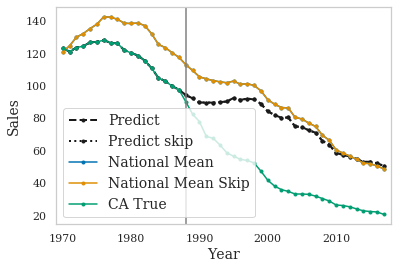

In [20]:
yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))

plt.plot(yearspad, capred ,'k--', lw=2, marker='.', label='Predict')
plt.plot(yearspad, capred2 ,'k:', lw=2, marker='.', label='Predict skip')
plt.plot(years, meansales, marker='.', label='National Mean')
plt.plot(years, meansalesskip, marker='.', label='National Mean Skip')
plt.plot(years, casales, marker='.', label='CA True')
plt.axvline(years[i1], color='gray')
plt.xlim(years[0]-1, years[-1]+1)
plt.grid(which='both')
plt.legend(fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Year', fontsize=14)


In [21]:
capred[np.where(yearspad==2000)[0][0]]- casales[np.where(years==2000)[0][0]]

42.457560318872495

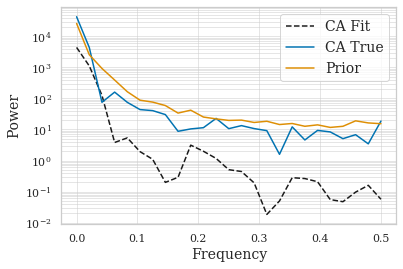

In [22]:
ff = getf(padl, padr)
plt.plot(ff, caps, 'k--', label='CA Fit')
# plt.plot(np.fft.rfftfreq(casales.size), psfunc(casales), label='CA unpad')
plt.plot(ff, pkca, label='CA True')
# plt.plot(np.fft.rfftfreq(casales.size), psf(xp[:, padl:-padr].mean(axis=0)), label='Nat-mean unpad')
plt.plot(ff, pkm, label='Prior')
plt.yscale('log')
plt.ylabel('Power', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.legend( fontsize=14)
plt.grid(which='both', lw=0.5)

# put it alltogether

In [23]:
statesales = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

ss = 'CA'
tmp = statesales['CA'].copy() 
statesales['CA'] = statesales[ss].copy()
statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)): salearray[i] = statesales[ils[i]]
    
# salearrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: salearrayca.append(statesales[ils[i]])
# salearrayca = np.array(salearrayca)

salearrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: salearrayskip.append(statesales[ils[i]])
salearrayskip = np.array(salearrayskip)
salearrayca = salearrayskip

casales = statesales['CA']
meansales = salearrayca.mean(axis=0)
meansalesskip = salearrayskip.mean(axis=0)

i1 = 18
yy = years.size



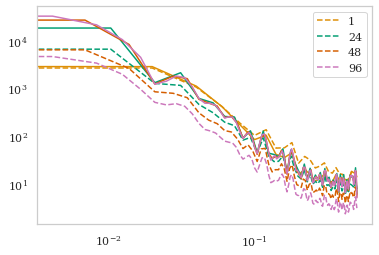

In [24]:
ii = 0 
preds = []
for padl, padr in [[1, 1],  [yy//2, yy//2], [yy, yy], [yy*2, yy*2]]:
# for padl, padr in [[yy//2, yy//2]]:
    ii +=1
    xp, means, pk, pkca = setupdata(salearrayskip, casales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayskip, padl, padr)
    pktrue = pkm/tfpad
    plt.plot(ffpad, pkm, 'C%d--'%ii, label=padl)
    plt.plot(ffpad, pktrue, 'C%d'%ii)
plt.loglog()
plt.grid()
plt.legend()



No handles with labels found to put in legend.


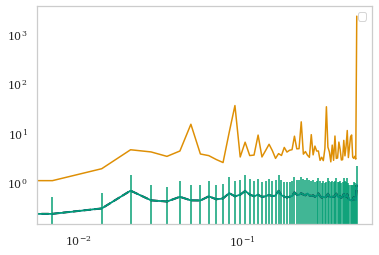

In [25]:
ii = 0 
preds = []
# for padl, padr in [[1, 1],  [yy//2, yy//2], [yy, yy], [yy*2, yy*2]]:
for padl, padr in [[yy, yy]]:
    ii +=1
    xp, means, pk, pkca = setupdata(salearrayskip, casales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad, xx = gettfprior(salearrayskip, padl, padr, samples=True, nsample=5000)
    pktrue = pkm/tfpad    
#     plt.plot(ffpad, pkm, 'C%d--'%ii, label=padl)
#     plt.plot(ffpad, pktrue, 'C%d'%ii)
    ps, pspad = xx[0][1], xx[1][1]
    tf = pspad.T.mean(axis=1)/ps.T.mean(axis=1)
    tf2 = (pspad/ps).T.mean(axis=1)
    plt.plot(ffpad, tfpad, 'k--', lw=2)
    plt.plot(ffpad, tf)
    plt.plot(ffpad, tf2)
    tferr = pspad.T.std(axis=1)/ps.T.mean(axis=1)
    tf2 = (pspad/ps).T.mean(axis=1)
    plt.errorbar(ffpad, tf, tferr)
    

#     plt.errorbar(ffpad, (pspad/ps).T.mean(axis=1), (pspad/ps).T.std(axis=1), color='k')
# plt.ylim(0.1, 10)
plt.loglog()
plt.grid()
plt.legend()



In [26]:
ffpad

array([0.        , 0.00694444, 0.01388889, 0.02083333, 0.02777778,
       0.03472222, 0.04166667, 0.04861111, 0.05555556, 0.0625    ,
       0.06944444, 0.07638889, 0.08333333, 0.09027778, 0.09722222,
       0.10416667, 0.11111111, 0.11805556, 0.125     , 0.13194444,
       0.13888889, 0.14583333, 0.15277778, 0.15972222, 0.16666667,
       0.17361111, 0.18055556, 0.1875    , 0.19444444, 0.20138889,
       0.20833333, 0.21527778, 0.22222222, 0.22916667, 0.23611111,
       0.24305556, 0.25      , 0.25694444, 0.26388889, 0.27083333,
       0.27777778, 0.28472222, 0.29166667, 0.29861111, 0.30555556,
       0.3125    , 0.31944444, 0.32638889, 0.33333333, 0.34027778,
       0.34722222, 0.35416667, 0.36111111, 0.36805556, 0.375     ,
       0.38194444, 0.38888889, 0.39583333, 0.40277778, 0.40972222,
       0.41666667, 0.42361111, 0.43055556, 0.4375    , 0.44444444,
       0.45138889, 0.45833333, 0.46527778, 0.47222222, 0.47916667,
       0.48611111, 0.49305556, 0.5       ])

In [27]:
pspad.shape

(5000, 73)

[]

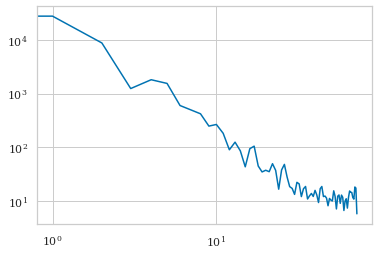

In [28]:
plt.plot(pktrue)
plt.loglog()

Expected difference :  [35.87621215]


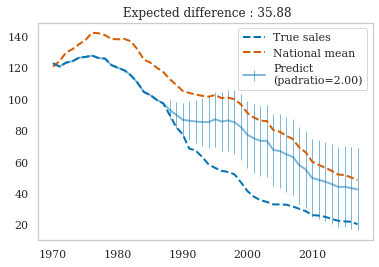

In [29]:
ii = 0 
preds = []
# for padl, padr in [[1, 1],  [10, 10], [yy//2, yy//2], [yy, yy]]:
for padl, padr in [[yy, yy]]:
    ii +=1
    xp, means, pk, pkca = setupdata(salearrayskip, casales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayskip, padl, padr)
    pktrue = pkm/tfpad
    pktrue[0:2] *=1
    
    p0 = np.ones(pkm.size*2)
    tomin = lambda p: chisq(p, means, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
        
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    preds.append([capred, err])

    if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label='Predict\n(padratio=%.2f)'%(2*padl/yy))
    else: plt.errorbar(years, capred[padl:], err[padl:], alpha=0.5, lw=2, elinewidth=1, label=ii)
    print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
    plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
plt.plot(years, casales, 'b--', lw=2, label='True sales')
plt.plot(years, meansales, 'r--', lw=2, label='National mean')
plt.grid()
plt.legend()

capredfid, errfid, covfid = capred[padl:-padr].copy(), err[padl:-padr].copy(), cov[padl:-padr, padl:-padr].copy()
# plt.xlim(years[i1], years[-1])
# plt.ylim(20, 100)

In [30]:
# ii = 0 
# preds = []
# # for padl, padr in [[1, 1],  [10, 10], [yy//2, yy//2], [yy, yy]]:
# for padl, padr in [[yy, yy]]:
#     ii +=1
#     xp, means, pk, pkca = setupdata(salearrayskip, casales, padl, padr)
#     pkm = pk.mean(axis=0)
#     ffpad  = getf(padl, padr)
#     tfpad = gettfprior(salearrayskip, padl, padr)
#     pktrue = pkm/tfpad
#     pktrue[0:2] *=2
    
#     p0 = np.ones(pkm.size*2)
#     tomin = lambda p: chisq(p, means, casales, pktrue, padl)
#     pp = minimize(tomin, p0).x
#     capred = pred(pp, means)
        
#     cov = getcov(pktrue, padl, padr)
#     err = cov.diagonal()**0.5
#     preds.append([capred, err])

#     if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label='Predict\n(padratio=%.2f)'%(2*padl/yy))
#     else: plt.errorbar(years, capred[padl:], err[padl:], alpha=0.5, lw=2, elinewidth=1, label=ii)
#     print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
#     plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
# plt.plot(years, casales, 'b--', lw=2, label='True sales')
# plt.plot(years, meansales, 'r--', lw=2, label='National mean')
# plt.grid()
# plt.legend()

# capredfid, errfid, covfid = capred[padl:-padr].copy(), err[padl:-padr].copy(), cov[padl:-padr, padl:-padr].copy()
# # plt.xlim(years[i1], years[-1])
# # plt.ylim(20, 100)

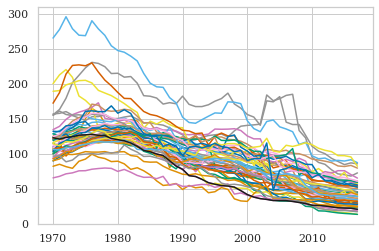

In [31]:
for ii in ils:
    plt.plot(years, statesales[ils[ii]])
plt.plot(years, casales, 'k')


# YJ transform


In [32]:
import numpy as np
import sympy as sp
from sympy.utilities.autowrap import ufuncify


x_sp = sp.Symbol('x_sp', real=True)
eta_sp = sp.Symbol('eta_sp', real=True)
eps_sp = sp.Symbol('eps_sp', real=True)
beta_sp = sp.Symbol('beta_sp', positive=True)
_yj_n = 4
_sp_eps = 1e-8


def yj_nested_tool(yj_n, n, yj_1 = None):
    
    if yj_1 is None:
        yj_1 = yj_n
    
    if n == 1:
        return yj_n
    
    elif n > 1:
        return yj_nested_tool(sp.lambdify([x_sp, eps_sp], yj_1(yj_n(x_sp, eps_sp), eps_sp)), n - 1, yj_1)
    
    else:
        raise ValueError
        
        
yj_sp_p = sp.lambdify([x_sp, eps_sp], ((x_sp + 1)**(1 + eps_sp) - 1) / (1 + eps_sp), 'sympy')
yj_sp_n = sp.lambdify([x_sp, eps_sp], -((-x_sp + 1)**(1 - eps_sp) - 1) / (1 - eps_sp), 'sympy')

jy_sp_p = sp.lambdify([x_sp, eps_sp], ((1 + eps_sp) * x_sp + 1)**(1 / (1 + eps_sp)) - 1, 'sympy')
jy_sp_n = sp.lambdify([x_sp, eps_sp], -(-(1 - eps_sp) * x_sp + 1)**(1 / (1 - eps_sp)) + 1, 'sympy')

sa_sp_p = sp.lambdify([x_sp, eta_sp], sp.sinh(eta_sp * x_sp) / eta_sp, 'sympy')
sa_sp_o = sp.lambdify([x_sp, eta_sp], x_sp, 'sympy')
sa_sp_n = sp.lambdify([x_sp, eta_sp], sp.asinh(eta_sp * x_sp) / eta_sp, 'sympy')

_to_gauss = ufuncify(args = [x_sp, eta_sp, eps_sp, beta_sp],
                     expr = sp.Piecewise((sa_sp_o(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, sp.And(eta_sp > -_sp_eps, eta_sp < _sp_eps, x_sp >= 0)),
                                         (sa_sp_o(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, sp.And(eta_sp > -_sp_eps, eta_sp < _sp_eps, x_sp < 0)),
                                         (sa_sp_p(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, sp.And(eta_sp > 0, x_sp >= 0)),
                                         (sa_sp_p(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, sp.And(eta_sp > 0, x_sp < 0)),
                                         (sa_sp_n(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, sp.And(eta_sp < 0, x_sp >= 0)),
                                         (sa_sp_n(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, sp.And(eta_sp < 0, x_sp < 0)),
                                         (sp.nan, True)),
                     backend='cython')
#                      backend='numpy')

_to_gauss_g = ufuncify(args = [x_sp, eta_sp, eps_sp, beta_sp],
                     expr = sp.Piecewise((sp.diff(sa_sp_o(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, x_sp, 1), sp.And(eta_sp > -_sp_eps, eta_sp < _sp_eps, x_sp >= 0)),
                                         (sp.diff(sa_sp_o(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, x_sp, 1), sp.And(eta_sp > -_sp_eps, eta_sp < _sp_eps, x_sp < 0)),
                                         (sp.diff(sa_sp_p(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, x_sp, 1), sp.And(eta_sp > 0, x_sp >= 0)),
                                         (sp.diff(sa_sp_p(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, x_sp, 1), sp.And(eta_sp > 0, x_sp < 0)),
                                         (sp.diff(sa_sp_n(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, x_sp, 1), sp.And(eta_sp < 0, x_sp >= 0)),
                                         (sp.diff(sa_sp_n(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp, x_sp, 1), sp.And(eta_sp < 0, x_sp < 0)),
                                         (sp.nan, True)),
                     backend='cython')
#                      backend='numpy')

_from_gauss = ufuncify(args = [x_sp, eta_sp, eps_sp, beta_sp],
                     expr = sp.Piecewise((yj_nested_tool(jy_sp_p, _yj_n)(sa_sp_o(x_sp / beta_sp, eta_sp), eps_sp) * beta_sp, sp.And(eta_sp > -_sp_eps, eta_sp < _sp_eps, x_sp >= 0)),
                                         (yj_nested_tool(jy_sp_n, _yj_n)(sa_sp_o(x_sp / beta_sp, eta_sp), eps_sp) * beta_sp, sp.And(eta_sp > -_sp_eps, eta_sp < _sp_eps, x_sp < 0)),
                                         (yj_nested_tool(jy_sp_p, _yj_n)(sa_sp_n(x_sp / beta_sp, eta_sp), eps_sp) * beta_sp, sp.And(eta_sp > 0, x_sp >= 0)),
                                         (yj_nested_tool(jy_sp_n, _yj_n)(sa_sp_n(x_sp / beta_sp, eta_sp), eps_sp) * beta_sp, sp.And(eta_sp > 0, x_sp < 0)),
                                         (yj_nested_tool(jy_sp_p, _yj_n)(sa_sp_p(x_sp / beta_sp, eta_sp), eps_sp) * beta_sp, sp.And(eta_sp < 0, x_sp >= 0)),
                                         (yj_nested_tool(jy_sp_n, _yj_n)(sa_sp_p(x_sp / beta_sp, eta_sp), eps_sp) * beta_sp, sp.And(eta_sp < 0, x_sp < 0)),
                                         (sp.nan, True)),
                     backend='cython')
#                      backend='numpy')


def nl_vectorizer(fun):
    
    def fun_v(zz, nl):
        
        zz = np.atleast_1d(zz)
        nl = np.asarray(nl)
        
        if nl.shape[-1] == 2:
            
            nl = np.concatenate((nl, np.ones((*nl.shape[:-1], 1))), axis=-1)  # set default value of beta to 1
        
        if zz.ndim == 1 and nl.ndim == 1 and nl.shape[-1] == 3: # case I: zz is a bunch of the same variable, with the same NL parameter
                                                                # that is, zz is (# of samples,), nl is (3,)
            
            _x_sp = zz
            _eta_sp = np.tile(nl[0], zz.shape[0])
            _eps_sp = np.tile(nl[1], zz.shape[0])
            _beta_sp = np.tile(nl[2], zz.shape[0])
            _results = fun(_x_sp, _eta_sp, _eps_sp, _beta_sp)
            return _results
        
        elif zz.ndim == 2 and nl.ndim == 2 and nl.shape[-1] == 3: # case II: zz is (# of samples, # of dim), nl is (# of dim, 3)
            
            _x_sp = zz.flatten()
            _eta_sp = np.tile(nl[:, 0], zz.shape[0])
            _eps_sp = np.tile(nl[:, 1], zz.shape[0])
            _beta_sp = np.tile(nl[:, 2], zz.shape[0])
            _results = fun(_x_sp, _eta_sp, _eps_sp, _beta_sp).reshape(zz.shape)
            return _results
        
        elif zz.ndim == 1 and nl.ndim == 2 and zz.shape[0] == nl.shape[0] and nl.shape[-1] == 3:
            # case III: zz is one single multidimensional sample, with different NL parameters in each dim
            # that is, zz is (# of dim,), nl is (# of dim, 3)
            
            _x_sp = zz
            _eta_sp = np.copy(nl[:, 0])
            _eps_sp = np.copy(nl[:, 1])
            _beta_sp = np.copy(nl[:, 2])
            _results = fun(_x_sp, _eta_sp, _eps_sp, _beta_sp)
            
            return _results
        
        else:
            
            raise ValueError
            
    return fun_v


to_gauss = nl_vectorizer(_to_gauss)
to_gauss_g = nl_vectorizer(_to_gauss_g)
from_gauss = nl_vectorizer(_from_gauss)


def norm_logpdf(x, mean, hess, normalized=False):
    
    result = -0.5 * (x - mean) * hess * (x - mean)
    if normalized:
        result += 0.5 * np.log(hess) - 0.5 * np.log(2 * np.pi)
    return result

def log_q(xx, mean, hess, nl, normalized=False):
    
    yy = to_gauss(xx - mean, nl)
    return (norm_logpdf(yy, np.zeros_like(mean), hess, normalized) + np.log(np.abs(to_gauss_g(xx - mean, nl)))).reshape(xx.shape)


In [33]:
from scipy.optimize import curve_fit as cf
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

def gauss(x, a, mu, s):
# def gauss(x, p):
#     a, mu, s = p
    norm = 1/np.sqrt(2*np.pi*s**2)
#     norm = 1
    return a*norm*np.exp(-0.5*((x-mu)/s)**2)

def fitgauss(xx, bins, normed):
    h, x = np.histogram(xx, bins=bins, normed=normed)
    x = x[1:] + x[:-1]
    x /= 2 
    p0 = [h.max(), xx.mean(), xx.std()]
    ftomin = lambda p: ((gauss(x, *p) - h)**2).sum()
    pp = minimize(ftomin, p0, method='Nelder-Mead', options={'maxiter':5000})
    print('mu=%.2f, s=%.2f'%(pp.x[1],pp.x[2]))
#     pp = cf(gauss, x, h, p0, )[0]
    return (x, gauss(x, *pp.x))

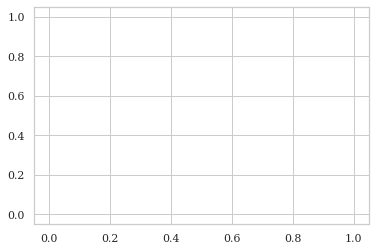

In [34]:
# @interact(mu=(-3,3,0.01), sig=(0.01,40,0.01), eta=(-2,2,0.01), eps=(-2,2,0.01), beta=(-10,10,0.01))
@interact(mu=(-3,3,0.01), sig=(0.01,3,0.01), eta=(-1,1,0.01), eps=(-1,1,0.01), beta=(-10,10,0.01))
def foo(mu, sig, eta, eps, beta):
    xx = np.linspace(-5,5,1000)
    plt.plot(xx, np.exp(log_q(xx, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True)))

### Transform data

In [35]:
statesales = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

ss = 'CA'
tmp = statesales['CA'].copy() 
statesales['CA'] = statesales[ss].copy()
statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)): salearray[i] = statesales[ils[i]]
    
# salearrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: salearrayca.append(statesales[ils[i]])
# salearrayca = np.array(salearrayca)

salearrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: salearrayskip.append(statesales[ils[i]])
salearrayskip = np.array(salearrayskip)
salearrayca = salearrayskip

casales = statesales['CA']
meansales = salearrayca.mean(axis=0)
meansalesskip = salearrayskip.mean(axis=0)

i1 = 18
yy = years.size



/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


[-4.86836747e+00  1.97721879e+01  1.45422567e-02 -1.76634118e-01
  2.14989626e+01]


/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


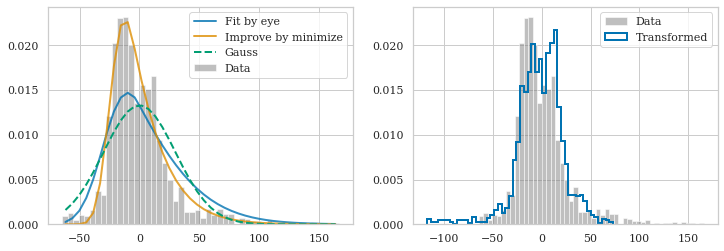

In [36]:
##Minimize 

# tdata = salearray.copy()
tdata = salearrayca.copy()
dd = (tdata - tdata.mean(axis=0)).flatten()
# ddy, ddx = np.histogram(dd, bins=50, normed=True, range=[-100, 100])
ddy, ddx = np.histogram(dd, bins=40, normed=True)
ddx = (ddx[1:] + ddx[:-1])*0.5
ddx = ddx.astype('float64')
ddy2, ddx2 = np.histogram(dd, bins=20, normed=True)
ddx2 = (ddx2[1:] + ddx2[:-1])*0.5
ddx2 = ddx2.astype('float64')


def tomin(p, rety = False):
    mu, sig, eta, eps, beta = p
    yy = np.exp(log_q(ddx, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
    yy2 = np.exp(log_q(ddx2, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
    if rety: return yy
    return sum((yy-ddy)**2) + sum((yy2-ddy2)**2) #+ skew(dzt)/2. + kurtosis(dzt)/2.
    
    
# p0 = [-3., 19., -0.3, -0.12, 40.]
# p0 = [-5., 19., 0., -0.1, 10.]
p0 = [0., 30., 0.01, -.1, 20.]
pinit = p0
# pp = minimize(tomin, pinit, method='Nelder-Mead', options={'maxiter': 10000, 'maxfev':20000, 'xatol': 1e-7, 'fatol': 1e-7, "maxfev":10000, 'ftol':1e-10, 'rtol':1e-10})
ppnl = minimize(tomin, pinit,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10, 'maxiter': 20000})
print(ppnl.x)


mu, sig, eta, eps, beta = ppnl.x
nl = np.array([eta, eps, beta])
yy = to_gauss((dd.astype('float64') - mu), nl)
yyl = to_gauss((dd.astype('float64') - mu), [0.,0.,1.]) 
yysalearrayca = yy.reshape(tdata.shape[0], -1)

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.hist(dd, bins=50, normed=True, label='Data', alpha=0.5, color='gray')
plt.plot(ddx, tomin(p0, rety=True), label='Fit by eye', lw=2, alpha=0.8)
plt.plot(ddx, tomin(ppnl.x, rety=True), label='Improve by minimize', lw=2, alpha=0.8)
plt.plot(ddx, tomin([p0[0], p0[1], 0., 0., 1.], rety=True), '--', lw=2, label='Gauss')
plt.legend()

plt.subplot(122)
plt.hist(dd, bins=50, normed=True, label='Data', alpha=0.5, color='gray')
plt.hist(yy, bins=50, normed=True, histtype='step', label='Transformed', lw=2)
# plt.hist(dd, bins=50, normed=True, label=r'Data',  color='gray', alpha=0.5)
# plt.hist(np.random.normal(mu, 1/sig, size=1000), bins=50, normed=True, histtype='step', label='Data/sig**2')
plt.legend()
# plt.yscale('log')
plt.show()

/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


mu=-0.00, s=-20.30
mu=-0.16, s=-19.19


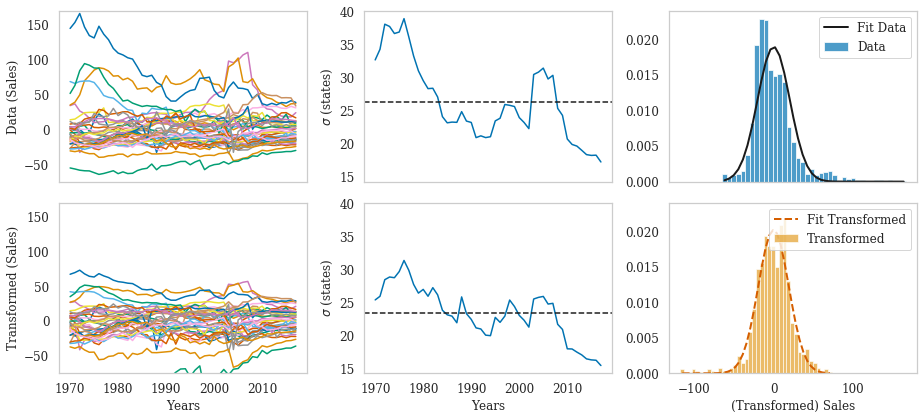

In [37]:
# ##Minimize 

# dd = (salearrayca - salearrayca.mean(axis=0)).flatten()
# # ddy, ddx = np.histogram(dd, bins=50, normed=True, range=[-100, 100])
# ddy, ddx = np.histogram(dd, bins=50, normed=True)
# ddx = (ddx[1:] + ddx[:-1])*0.5
# ddx = ddx.astype('float64')


fig, axar = plt.subplots(2, 3, figsize = (13, 6), sharex='col', sharey='col')
fsize=12

axis = axar[0, 0]
for i in range(salearrayskip.shape[0]):
    axis.plot(years, (salearrayskip-salearrayskip.mean(axis=0))[i])
axis.set_ylabel('Data (Sales)', fontsize=fsize)
axis.set_ylim(-75, 170)

ssize = salearrayskip.shape[0]
bootstd = np.zeros_like(salearrayskip)
for i in range(ssize):
    tmp = np.array([salearrayskip[j] for j in range(ssize) if j!=i])
    bootstd[i] = tmp.std(axis=0)
bootstd = bootstd.std(axis=0)
# axar[0, 1].errorbar(years, salearrayskip.std(axis=0), bootstd)
axar[0, 1].plot(years, salearrayskip.std(axis=0))
axar[0, 1].axhline(salearrayskip.std(axis=0).mean(), color='k', ls="--")
axar[0, 1].set_ylabel('$\sigma$ (states)', fontsize=fsize)


axis = axar[1, 0]
for i in range(salearrayskip.shape[0]):
    axis.plot(years, yysalearrayca[i])
axis.set_ylabel('Transformed (Sales)', fontsize=fsize)
axis.set_ylim(-75, 170)
axar[1, 0].set_xlabel('Years', fontsize=fsize)

ssize = salearrayskip.shape[0]
bootstd = np.zeros_like(salearrayskip)
for i in range(ssize):
    tmp = np.array([yysalearrayca[j] for j in range(ssize) if j!=i])
    bootstd[i] = tmp.std(axis=0)
bootstd = bootstd.std(axis=0)
# axar[1, 1].errorbar(years, yysalearrayca.std(axis=0), bootstd)
axar[1, 1].plot(years, yysalearrayca.std(axis=0))
axar[1, 1].axhline(yysalearrayca.std(axis=0).mean(), color='k', ls="--")
axar[1, 1].set_ylabel('$\sigma$ (states)', fontsize=fsize)
axar[1, 1].set_xlabel('Years', fontsize=fsize)

axis = axar[0, 2]
bins, normed = 40, True
axis.hist(dd, bins=bins, normed=normed, label='Data', alpha=0.7, color='C0')
axis.plot(*fitgauss(dd, bins, normed), 'k', lw=2, label='Fit Data')
axis.legend(fontsize=fsize)

axis = axar[1, 2]
axis.hist(yy, bins=bins, normed=normed,  label='Transformed', alpha=0.6, color='C1')
axis.plot(*fitgauss(yy, bins, normed), 'r--', lw=2, label='Fit Transformed')
axis.legend(fontsize=fsize)
axis.set_xlabel('(Transformed) Sales', fontsize=fsize)

for axis in axar.flatten():
    axis.grid()
    axis.tick_params(axis='both', which='major', labelsize=fsize)
plt.tight_layout()
    

## predict

p0 = [0., 30, 0.01, -.1, 20.]
It seems to be sensitive to this starting point for some reason

In [38]:
from scipy.optimize import leastsq

In [39]:
tdata = salearrayca.copy()
dd = (tdata - tdata.mean(axis=0)).flatten()
# ddy, ddx = np.histogram(dd, bins=50, normed=True, range=[-100, 100])
ddy, ddx = np.histogram(dd, bins=40, normed=True)
ddx = (ddx[1:] + ddx[:-1])*0.5
ddx = ddx.astype('float64')
ddy2, ddx2 = np.histogram(dd, bins=20, normed=True)
ddx2 = (ddx2[1:] + ddx2[:-1])*0.5
ddx2 = ddx2.astype('float64')


def tomin(p, rety = False):
    mu, sig, eta, eps, beta = p
    yy = np.exp(log_q(ddx, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
    yy2 = np.exp(log_q(ddx2, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
    if rety: return yy
    return sum((yy-ddy)**2) + sum((yy2-ddy2)**2) #+ skew(dzt)/2. + kurtosis(dzt)/2.
     
    
# p0 = [-3., 19., -0.3, -0.12, 40.]
# p0 = [-5., 19., 0., -0.1, 10.]
p0 = [0., 30., 0.01, -.1, 20.]
pinit = p0
# pp = minimize(tomin, pinit, method='Nelder-Mead', options={'maxiter': 10000, 'maxfev':20000, 'xatol': 1e-7, 'fatol': 1e-7, "maxfev":10000, 'ftol':1e-10, 'rtol':1e-10})
ppnl = minimize(tomin, pinit,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10, 'maxiter': 20000})
print(ppnl.x)





padl, padr = years.size, years.size
mu, sig, eta, eps, beta = ppnl.x
nl = np.array([eta, eps, beta])
# xpg = salearrayca-salearrayca.mean(axis=0)
xp = ((salearrayca - meansalesca)/stdsalesca).flatten()
xpg = to_gauss((xp.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)
xc = (casales - meansalesca)/stdsalesca
xcg = to_gauss((xc.astype('float64') - mu), nl)




###
xpgpad = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
ff = np.fft.rfftfreq(xpgpad[0].size)
pk = []
for i in range(xpgpad.shape[0]): pk.append(psfunc(xpgpad[i]))
pk = np.array(pk)
pkm = pk.mean(axis=0)
tfpad = gettfprior(xpgpad[:, padl:-padr], padl, padr, al=0)
pkprior = pkm/tfpad
cov = getcov(pkprior, padl, padr)
errg = cov.diagonal()**0.5

pkca = psfunc(np.pad(xcg, (padl, padr), mode='constant', constant_values=0))


# 

/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys


[-4.86836747e+00  1.97721879e+01  1.45422567e-02 -1.76634118e-01
  2.14989626e+01]


In [40]:
meansalesca = salearrayca.mean(axis=0)
stdsalesca = 1#salearrayca.std(axis=0)
dd = (salearrayca - meansalesca)
dd /= stdsalesca
dd = dd.flatten()

# dd = (salearray - salearray.mean(axis=0)).flatten()
ddx, ddy = [], []
for bins in [20, 40]:
    ty, tx = np.histogram(dd, bins=bins, normed=True)
    ddx.append(((tx[1:] + tx[:-1])*0.5).astype('float64'))
    ddy.append(ty)


    

    
def tomin(p, rety = False, nd=0, fitbeta=True):
    mu, sig, eta, eps, beta = p
    if not fitbeta: beta = dd.std()
    if rety: 
        yy = np.exp(log_q(ddx[nd], np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
        return yy
    else:
        toret = 0
        if sig < 0: return 1e10
        for idd, dx in enumerate(ddx):
            yy = np.exp(log_q(dx, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
            toret += sum((yy - ddy[idd])**2)
        return toret
    
    
# p0 = [-3., 19., -0.1, -0.12, 20.]
# # p0 = [-3., 20., 0.01, -.1, 10.]
p0 = [0., 30, 0.01, -.1, 20.]
ppnl = minimize(tomin, p0,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10, 'maxiter': 20000})

#if scacled
# p0 = [0, 1, -0.5, 0.2, 1.]
# ppnl = minimize(lambda x: tomin(x, fitbeta=True), p0,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10, 'maxiter': 20000})

print(ppnl.x)
ppnl1 = ppnl.copy()

# p0 = [dd.mean(), dd.std(), 0.1, 0.1, dd.std()]
# ppnl = minimize(lambda x: tomin(x, fitbeta=False, rety=True), p0,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10,                                                                             'maxiter': 20000})
# print(ppnl.x)

del dd
####################################


padl, padr = years.size, years.size
mu, sig, eta, eps, beta = ppnl.x
nl = np.array([eta, eps, beta])
# xpg = salearrayca-salearrayca.mean(axis=0)
xp = ((salearrayca - meansalesca)/stdsalesca).flatten()
xpg = to_gauss((xp.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)
xc = (casales - meansalesca)/stdsalesca
xcg = to_gauss((xc.astype('float64') - mu), nl)




###
xpgpad = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
ff = np.fft.rfftfreq(xpgpad[0].size)
pk = []
for i in range(xpgpad.shape[0]): pk.append(psfunc(xpgpad[i]))
pk = np.array(pk)
pkm = pk.mean(axis=0)
tfpad = gettfprior(xpgpad[:, padl:-padr], padl, padr, al=0)
pkprior = pkm/tfpad
cov = getcov(pkprior, padl, padr)
errg = cov.diagonal()**0.5

pkca = psfunc(np.pad(xcg, (padl, padr), mode='constant', constant_values=0))



/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


[-4.86836747e+00  1.97721879e+01  1.45422567e-02 -1.76634118e-01
  2.14989626e+01]


In [41]:
xpg1 = to_gauss((xp.astype('float64') - ppnl1['x'][0]), ppnl1['x'][2:]).reshape(salearrayca.shape[0], -1)



/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/chirag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]


mu=-0.00, s=-20.11
mu=-0.21, s=-19.02


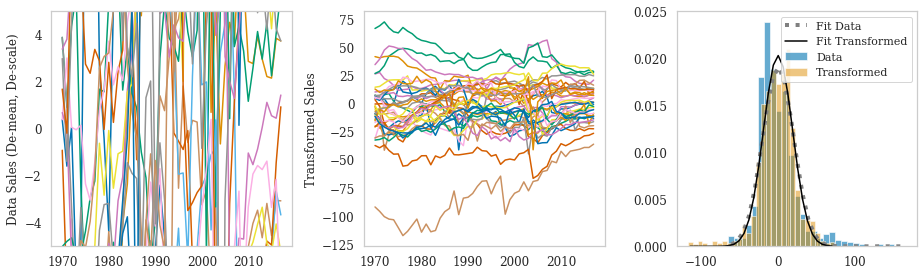

In [42]:
# ##Minimize 


fig, ax = plt.subplots(1, 3, figsize = (13, 4))
fsize=12

axis = ax[0]
for i in range(salearrayskip.shape[0]):
    axis.plot(years, (salearrayskip-salearrayskip.mean(axis=0))[i])
#     axis.plot(years, ((salearrayskip-salearrayskip.mean(axis=0))/salearrayskip.std(axis=0))[i])
axis.set_ylabel('Data Sales (De-mean, De-scale)', fontsize=fsize)
axis.set_ylim(-75, 170)
axis.set_ylim(-5, 5)

axis = ax[1]
for i in range(salearrayskip.shape[0]):
    axis.plot(years, xpg[i], 'C%d'%(i%9))
#     axis.plot(years, xpg1[i], 'C%d--'%(i%9))
axis.set_ylabel('Transformed Sales', fontsize=fsize)
# axis.set_ylim(-5, 5)


axis = ax[2]
bins, normed = 30, True
axis.hist(xp.flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
axis.hist(xpg.flatten(), bins=bins, normed=normed,  label='Transformed', alpha=0.5, color='C1')
# axis.hist(xpg1.flatten(), bins=bins, normed=normed,  label='Transformed', alpha=0.4, color='C2')
axis.plot(*fitgauss(xp.flatten(), bins, normed), ':', color='gray', lw=4, label='Fit Data')
axis.plot(*fitgauss(xpg.flatten(), bins, normed), '-', color='black', lw=1.5, label='Fit Transformed')
axis.legend(fontsize=fsize-1)

for axis in ax.flatten():
    axis.grid()
    axis.tick_params(axis='both', which='major', labelsize=fsize)
plt.tight_layout()
    

In [43]:

def chisq2(p, cadata, priork=1, padl=0, sigma=1, i1=18,verbose=False, pred=False):
    u, v = p[:p.size//2], p[p.size//2:]
    s = u + 1j*v
    x = np.fft.irfft(s, norm='ortho')
    ps = abs(s)**2
    if pred: return x
    res = (x[padl:padl+i1] - cadata[:i1])**2 / sigma**2
    prior = ps/priork 
    if verbose: print(sum(res), sum(prior))
    return sum(res) + sum(prior)

p0 = np.ones(pkm.size*2)
tomin = lambda p: chisq2(p, xcg, pkprior, padl=padl, sigma=0.01)
pp = minimize(tomin, p0).x

In [44]:
capredg = chisq2(pp, 0, pred=True)
deriv = (from_gauss(capredg*1.01, nl) - from_gauss(capredg*0.99, nl))/(capredg*0.02)
err = (errg*deriv)[padl:-padr] *stdsalesca

capredup = (from_gauss(capredg+errg, nl)[padl:-padr] + mu)*stdsalesca + meansalesca
capreddn = (from_gauss(capredg-errg, nl)[padl:-padr]+ mu)*stdsalesca + meansalesca
capred = (from_gauss(capredg, nl)[padl:-padr]+mu)*stdsalesca + meansalesca
casalesg = to_gauss((casales.astype('float64')-meansalesca )/stdsalesca-mu, nl)

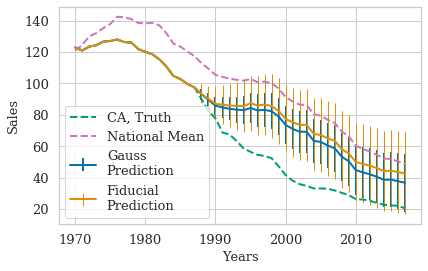

In [45]:
fsize = 13
plt.figure(figsize = (6.5, 4))

plt.errorbar(years, capred, err, color='C0', label='Gauss\nPrediction', lw=2, elinewidth=2)
plt.errorbar(years, capredfid, errfid, color='C1', elinewidth=1, label='Fiducial\nPrediction', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)

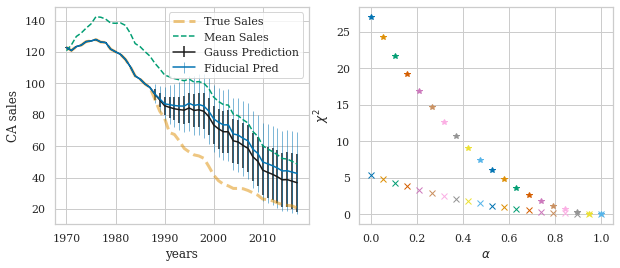

In [46]:
fsize = 12
plt.figure(figsize = (10, 4))
plt.subplot(121)

plt.errorbar(years, capred, err, color='k', label='Gauss Prediction')
plt.errorbar(years, capredfid, errfid, elinewidth=0.5, label='Fiducial Pred')
plt.plot(years, casales, '--', alpha=0.5, lw=3, label='True Sales')
plt.plot(years, meansales, '--', label='Mean Sales')
plt.legend()
plt.xlabel('years', fontsize=fsize)
plt.ylabel('CA sales', fontsize=fsize)

plt.subplot(122)
#Chi sq in Data space. Wrong
# covpred = cov[padl+i1:-padr, padl+i1:-padr]
# icovpred = np.linalg.inv(covpred)
# mod = lambda al: capred[i1:] + al*(casales[i1:] - capred[i1:])
# sig = lambda al: np.dot(np.dot(mod(al)-casales[i1:], icovpred), mod(al)-casales[i1:])
# alpha = np.linspace(0, 1, 20)
# for ia in range(alpha.size):
#     plt.plot(alpha[ia], sig(alpha[ia]), 'o')
    
#Fiducial    
covpred = covfid[i1:, i1:]
icovpred = np.linalg.inv(covpred)
mod = lambda al: capredfid[i1:] + al*(casales[i1:] - capredfid[i1:])
sig = lambda al: np.dot(np.dot(mod(al)-casales[i1:], icovpred), mod(al)-casales[i1:])
alpha = np.linspace(0, 1, 20)
for ia in range(alpha.size):
    plt.plot(alpha[ia], sig(alpha[ia]), 'x')

#Chi sq in Gaussian
capredg = chisq2(pp, 0, pred=True)[padl:-padr]
covpred = cov[padl+i1:-padr, padl+i1:-padr]
icovpred = np.linalg.inv(covpred)
mod = lambda al: capredg[i1:] + al*(casalesg[i1:] - capredg[i1:])
sig = lambda al: np.dot(np.dot(mod(al)-xcg[i1:], icovpred), mod(al)-xcg[i1:])
alpha = np.linspace(0, 1, 20)
for ia in range(alpha.size):
    plt.plot(alpha[ia], sig(alpha[ia]), '*')
    
plt.xlabel(r'$\alpha$', fontsize=fsize)
plt.ylabel(r'$\chi^2$', fontsize=fsize)
plt.show()


In [47]:
capred0, capredg0, icovpred0, covpred0 = capred.copy(), capredg.copy(), icovpred.copy(), covpred.copy()

# 1D analysis

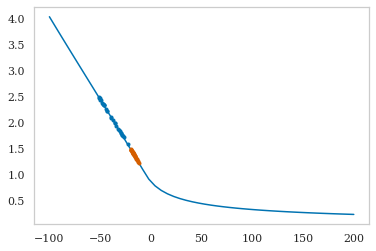

In [48]:
mod = lambda al: capred + al*(casales - capred)
def jacfunc(al):
    y = (mod(al) - meansalesca)[i1:]
    jac =  np.abs(to_gauss_g(y-mu, nl))
    return y, jac

xx = np.linspace(-100, 200)
jac = np.abs(to_gauss_g(xx - mu, nl))
plt.plot(xx, jac)
plt.plot(*jacfunc(1), 'b.')
plt.plot(*jacfunc(0), 'r.')
# plt.plot(x, y, '.')
plt.grid()

1.318756630704238e-06 18455.153899071036 1.318756630704238e-06
1.0 3691969502.195701 1.0


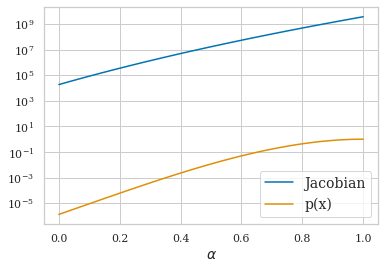

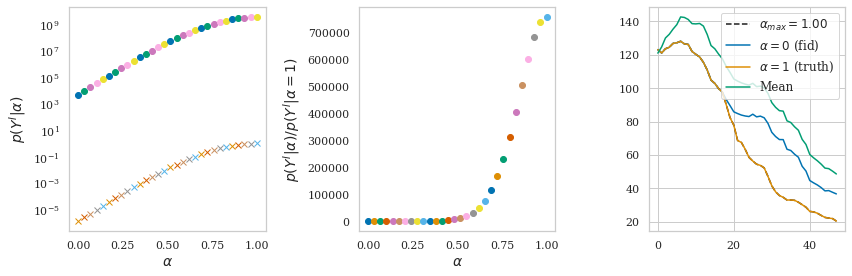

In [49]:
alpha = np.linspace(0, 1, 30)

icovfid = np.linalg.inv(covfid[i1:, i1:])
def sigfid(al):
    mod = capredfid + al*(casales - capredfid)
    diff = (casales-mod)[i1:]
    chi2 = np.dot(np.dot(diff, icovfid), diff)
    return np.exp(-chi2/2.)


capredg = chisq2(pp, 0, pred=True)
capred = from_gauss(capredg, nl)[padl:-padr] + mu + meansalesca
covpred = cov[padl+i1:-padr, padl+i1:-padr]
icovpred = np.linalg.inv(covpred)
mod = lambda al: capred + al*(casales - capred)

def pxfunc(al):
    y = (mod(al) - meansalesca)[i1:]
    yg = to_gauss(y-mu, nl)
    diff = yg - casalesg[i1:]
#     diff = yg - capredg[padl+i1:-padr]
    px = np.exp(-0.5*np.dot(np.dot(diff, icovpred), diff))
    return px

def jacfunc(al):
    y = (mod(al) - meansalesca)[i1:]
    jac =  np.abs(np.prod(to_gauss_g(y-mu, nl)))
    return jac


def sig(al, usejac=False):
    px = pxfunc(al)
    jac =  jacfunc(al)
    if usejac: return px*jac
    else: return px
    
print(pxfunc(0), jacfunc(0), sig(0))
print(pxfunc(1), jacfunc(1), sig(1))


###
jac = [jacfunc(alpha[ia]) for ia in range(alpha.size)]
px = [pxfunc(alpha[ia]) for ia in range(alpha.size)]
plt.plot(alpha, jac, label='Jacobian')
plt.plot(alpha, px, label='p(x)')
plt.legend(fontsize=14)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.yscale('log')

###
plt.figure(figsize = (12, 4))
plt.subplot(131)
ialmax, almax =None,  -1 
for ia in range(alpha.size):
    plt.plot(alpha[ia], jacfunc(1)*sig(alpha[ia]), 'o')
    plt.plot(alpha[ia], pxfunc(alpha[ia]), 'x')
    if almax < sig(alpha[ia]):
        almax = sig(alpha[ia])
        ialmax = ia
plt.grid()
plt.yscale('log')
plt.ylabel(r'$p(Y^I|\alpha)$', fontsize=14)
plt.xlabel(r'$\alpha$', fontsize=14)

plt.subplot(132)
for ia in range(alpha.size):
    plt.plot(alpha[ia], sig(alpha[ia])/sig(0), 'o')

plt.ylabel(r'$p(Y^I|\alpha)/p(Y^I|\alpha=1)$', fontsize=14)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.grid()

plt.subplot(133)
plt.plot(mod(alpha[ialmax]), 'k--', label=r'$\alpha_{max} = %.2f$'%alpha[ialmax])
plt.plot(mod(0), label=r'$\alpha = 0$ (fid)')
plt.plot(mod(1), label=r'$\alpha = 1$ (truth)')
plt.plot(meansales, label='Mean')
plt.legend(fontsize=12)
plt.tight_layout()

In [50]:
synth = np.loadtxt('/home/chirag/Research/Projects/TobaccoTax/scripts/output_synth/all_lag/CA_outcome.txt')

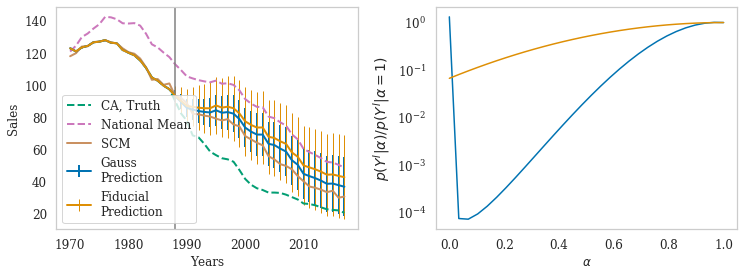

FileNotFoundError: [Errno 2] No such file or directory: './figs/tmp.png'

<Figure size 432x288 with 0 Axes>

In [51]:
fsize = 12
plt.figure(figsize = (10.5, 4))
plt.subplot(121)

plt.errorbar(years, capred, err, color='C0', label='Gauss\nPrediction', lw=2, elinewidth=2)
plt.errorbar(years, capredfid, errfid, color='C1', elinewidth=1, label='Fiducial\nPrediction', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.plot(years, synth[:, 1], 'C5', alpha=1, lw=2, label='SCM')
plt.axvline(years[i1], color='gray')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)
plt.grid()
# plt.errorbar(years, capred, err, color='k', label='Gauss Prediction')
# # plt.errorbar(years, capredfid, errfid, elinewidth=0.5, label='Fiducial Pred')
# plt.plot(years, casales, '--', alpha=0.5, lw=3, label='True Sales')
# plt.plot(years, meansales, '--', label='Mean Sales')
# plt.legend()
# plt.xlabel('years', fontsize=fsize)
# plt.ylabel('CA sales', fontsize=fsize)

plt.subplot(122)
    
#Fiducial    
ialmax, almax =None,  -1 
pxs = [jacfunc(1)*sig(alpha[ia]) for ia in range(alpha.size)]
pxfid = [sigfid(alpha[ia]) for ia in range(alpha.size)]
plt.plot(alpha, pxs/pxs[-1] /(1e-6+alpha), label='Gauss\nPrediction')
plt.plot(alpha, pxfid/pxfid[-1], label='Fiducial\nPrediction')
# plt.plot(alpha, pxs/pxs[0], label='Gauss\nPrediction')
# plt.plot(alpha, pxfid/pxfid[0], label='Fiducial\nPrediction')
plt.grid()
plt.gcf().axes[1].tick_params(which='both', labelsize=fsize)
plt.yscale('log')
plt.ylabel(r'$p(Y^I|\alpha)$', fontsize=fsize)
plt.ylabel(r'$p(Y^I|\alpha)/p(Y^I|\alpha=1)$', fontsize=14)
plt.xlabel(r'$\alpha$', fontsize=fsize)
plt.tight_layout()
plt.show()
plt.savefig('./figs/tmp.png')

In [ ]:
fsize = 12
plt.figure(figsize = (8, 5))

plt.errorbar(years, capred, err, color='C0', label='Gauss\nPrediction', lw=2, elinewidth=2)
plt.errorbar(years, capredfid, errfid, color='C1', elinewidth=1, label='Fiducial\nPrediction', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.plot(years, synth[:, 1], 'C5', alpha=1, lw=2, label='SCM')
plt.axvline(years[i1], color='gray')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)
plt.grid()
# plt.errorbar(years, capred, err, color='k', label='Gauss Prediction')
# # plt.errorbar(years, capredfid, errfid, elinewidth=0.5, label='Fiducial Pred')
# plt.plot(years, casales, '--', alpha=0.5, lw=3, label='True Sales')
# plt.plot(years, meansales, '--', label='Mean Sales')
# plt.legend()
# plt.xlabel('years', fontsize=fsize)
# plt.ylabel('CA sales', fontsize=fsize)

plt.savefig('./figs/counterftmp.png')

In [ ]:
plt.plot(alpha, pxs/pxs[-1], label='Gauss\nPrediction')


In [ ]:
plt.plot(alpha, pxs/pxs[-1] *(1e3 -1e3*alpha + 10), label='Gauss\nPrediction')
plt.yscale('log')


In [ ]:
print(1/sig(0))

# 2D analysis

In [ ]:
plt.subplot(121)
xx = years-years[0]
ppoly = []
# for iis, ss  in enumerate(salearray):
#     p = np.polyfit(xx, ss-meansales, 2)
#     ppoly.append(p)
#     plt.plot(xx, ss-meansales)
#     plt.plot(xx, p[0]*xx**2 + p[1]*xx**1 + p[2], '--')
# ppoly = np.array(ppoly)
for iis, ss  in enumerate(salearrayca):
    p = np.polyfit(xx, ss-meansalesca, 2)
    ppoly.append(p)
    plt.plot(xx, ss-meansalesca)
    plt.plot(xx, p[0]*xx**2 + p[1]*xx**1 + p[2], '--')
ppoly = np.array(ppoly)

plt.subplot(122)
xx = years[i1:]-years[i1]
ppolyi1 = []
for iis, ss  in enumerate(salearrayca):
    p = np.polyfit(xx, ss[i1:]-meansalesca[i1:], 2)
    ppolyi1.append(p)
    plt.plot(xx, ss[i1:]-meansalesca[i1:])
    plt.plot(xx, p[0]*xx**2 + p[1]*xx**1 + p[2], '--')
ppolyi1 = np.array(ppolyi1)
plt.show()

plt.subplot(131)
bins = 40

plt.hist(ppoly[:, 0], normed=True, bins=bins)
plt.hist(ppolyi1[:, 0],  normed=True, bins=bins, alpha=0.5)
# plt.axvline(bts[maxb], color='k')
plt.subplot(132)
plt.hist(ppoly[:, 1], normed=True, bins=bins)
plt.hist(ppolyi1[:, 1], normed=True, bins=bins, alpha=0.5)
# plt.axvline(als[maxa], color='k')
plt.subplot(133)
plt.plot(ppoly[:, 0], ppoly[:, 1], '.')
# plt.plot(ppolyi1[:, 0], ppolyi1[:, 1], '.')
# plt.hist(ppoly[:, 2])

In [ ]:
almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
als = np.round(np.arange(almin, almax, (almax-almin)/101.), 3)
btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()
# btmin, btmax = btmin-(btmax-btmin)/2., btmax+(btmax-btmin)/2.
print(almin, almax )
print(btmin, btmax )

In [ ]:
def mod(al, bt):
#     als, bts = np.ones_like(meansalesca), np.ones_like(meansalesca)
#     als[i1:], bts[i1:] = al, bt
#     m = als*meansalesca + bts*(from_gauss(capredg, nl)[padl:-padr] + mu)
    xx = years - years[i1]
    xx[xx<0] = 0
    p1 = xx*al
    p2 = xx**2 * bt
#     m = capredg[padl:-padr]+p1+p2
    m = capred+p1+p2
    return m


    
def sig(al, bt):
    y = (mod(al, bt) - meansalesca)[i1:]
    yg = to_gauss(y-mu, nl)
    diff = yg - casalesg[i1:]
    px = np.exp(-0.5*np.dot(np.dot(diff, icovpred), diff))
#     jac =  np.abs(np.prod(to_gauss_g(y-mu, nl)))
#     return np.log(px*jac)*-0.5
    return px#*jac
    


######################################

capredg = chisq2(pp, 0, pred=True)
capred = from_gauss(capredg, nl)[padl:-padr] + mu + meansalesca
covpred = cov[padl+i1:-padr, padl+i1:-padr]
icovpred = np.linalg.inv(covpred)


almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()
while True:
    als = np.round(np.arange(almin, almax, (almax-almin)/101.), 3)
    bts = np.round(np.arange(btmin, btmax, (btmax-btmin)/101.), 3)
    als = np.concatenate((als[als<0] , [0] , als[als>0]))
    bts = np.concatenate((bts[bts<0] , [0] , bts[bts>0]))
    ia1, ib1 = np.where(als ==0)[0][0], np.where(bts==0)[0][0]
    
    sigmatrix = np.zeros((als.size, bts.size))
    maxa, maxb = None, None
    sigmax = -1
    for ia, aa in enumerate(als):
        for ib, bb in enumerate(bts):
            chi = sig(aa, bb)
            if  chi > sigmax: 
                sigmax = chi
                maxa, maxb = ia, ib
            sigmatrix[ia, ib] = chi

    if abs(maxa/als.size) > 0.9: 
        print('Do als again for ')
        almin, almax = almin-(almax-almin)/2., almax+(almax-almin)/2.
    if abs(maxb/bts.size) > 0.9: 
        print('Do bts again for ')
        btmin, btmax = btmin-(btmax-btmin)/2., btmax+(btmax-btmin)/2.
    else: break

                
print(maxa, maxb, als[maxa], bts[maxb], sigmatrix[maxa, maxb], sigmatrix[ia1, ib1])


if abs(maxa/als.size) > 0.9: print('Do als again')
if abs(maxb/bts.size) > 0.9: print('Do bts again')


In [ ]:
pa = np.trapz(als*0+1, als)
pb = np.trapz(bts*0+1, bts)
print(pa, pb)

da, db = np.diff(als)[0], np.diff(bts)[0]
sigmatrix.max(), (sigmatrix/pa/pb*da*db).sum(),  (sigmatrix[ia1, ib1]), (sigmatrix/pa/pb*da*db).sum()/(sigmatrix[ia1, ib1])

In [ ]:
print(sigmatrix.max()/ sigmatrix[ia1, ib1])

In [ ]:
plt.imshow(sigmatrix)
plt.colorbar()

In [ ]:
plt.plot(mod(als[maxa], bts[maxb]), color='k', lw=3, alpha=0.5)
plt.plot(mod(als[ia1], bts[ib1]), 'k')

plt.plot(mod(als[maxa], bts[ib1]), 'C1-.')
plt.plot(mod(als[maxa], bts[-1]), 'C1--')
plt.plot(mod(als[maxa], bts[1]), 'C1:')

plt.plot(mod(als[ia1], bts[maxb]), 'C0-.')
plt.plot(mod(als[-1], bts[maxb]), 'C0--')
plt.plot(mod(als[1], bts[maxb]), 'C0:')
# plt.plot(mod(als[maxa], 1), 'C0:')
# plt.plot(mod(0, maxb), 'C1--')
# plt.plot(mod(1, maxb), 'C1:')
plt.plot(casales, 'g--')
plt.plot(meansalesca, 'g:')
plt.ylim(0, 170)

In [ ]:
fsize = 13
plt.figure(figsize = (10.5, 4))
plt.subplot(121)
plt.errorbar(years, capred, err, color='C0', label='Gauss\nPrediction', lw=2, elinewidth=2)
plt.plot(years, mod(als[maxa], bts[maxb]), color='C1', lw=2, alpha=1, label='Maximize')
plt.axvline(years[i1], color='gray')
# plt.errorbar(years, capredfid, errfid, color='C1', elinewidth=1, label='Fiducial\nPrediction', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)

plt.subplot(122)
plt.imshow(sigmatrix/sigmatrix[ia1, ib1], origin='lower')
plt.axhline(ia1, color='gray')
plt.axvline(ib1, color='gray')
plt.xlabel(r'$\beta$', fontsize=fsize)
plt.ylabel(r'$\alpha$', fontsize=fsize)
plt.colorbar()
ax = plt.gcf().axes[1]
ax.tick_params(which='both', labelsize=fsize)
locs, labels = plt.yticks()           
plt.yticks(locs[1:-1], als[locs[1:-1].astype('int')])
locs, labels = plt.xticks()           
plt.xticks(locs[1:-1], bts[locs[1:-1].astype('int')])
plt.tight_layout()

In [ ]:
pa = np.trapz(als*0+1, als)
pb = np.trapz(bts*0+1, bts)
print(pa, pb)

da, db = np.diff(als)[0], np.diff(bts)[0]
sigmatrix.max(), (sigmatrix/pa/pb*da*db).sum(),  (sigmatrix[ia1, ib1]), (sigmatrix/pa/pb*da*db).sum()/(sigmatrix[ia1, ib1])

### 2D prior

In [ ]:
print(almax, btmax)

In [ ]:
def mod(al, bt):
#     als, bts = np.ones_like(meansalesca), np.ones_like(meansalesca)
#     als[i1:], bts[i1:] = al, bt
#     m = als*meansalesca + bts*(from_gauss(capredg, nl)[padl:-padr] + mu)
    xx = years - years[i1]
    xx[xx<0] = 0
    p1 = xx*al
    p2 = xx**2 * bt
#     m = capredg[padl:-padr]+p1+p2
    m = capred+p1+p2
    return m


    
def sig(al, bt):
    y = (mod(al, bt) - meansalesca)[i1:]
    yg = to_gauss(y-mu, nl)
    diff = yg - casalesg[i1:]
    px = np.exp(-0.5*np.dot(np.dot(diff, icovpred), diff))
#     jac =  np.abs(np.prod(to_gauss_g(y-mu, nl)))
#     return np.log(px*jac)*-0.5
    return px#*jac
    


######################################

capredg = chisq2(pp, 0, pred=True)
capred = from_gauss(capredg, nl)[padl:-padr] + mu + meansalesca
covpred = cov[padl+i1:-padr, padl+i1:-padr]
icovpred = np.linalg.inv(covpred)


almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
almax = min(0, almax) #set zero

btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()
while True:
    als = np.round(np.arange(almin, almax, (almax-almin)/101.), 3)
    bts = np.round(np.arange(btmin, btmax, (btmax-btmin)/101.), 3)
    als = np.concatenate((als[als<0] , [0] , als[als>0]))
    bts = np.concatenate((bts[bts<0] , [0] , bts[bts>0]))
    ia1, ib1 = np.where(als ==0)[0][0], np.where(bts==0)[0][0]
    
    sigmatrix = np.zeros((als.size, bts.size))
    maxa, maxb = None, None
    sigmax = -1
    for ia, aa in enumerate(als):
        for ib, bb in enumerate(bts):
            chi = sig(aa, bb)
            if  chi > sigmax: 
                sigmax = chi
                maxa, maxb = ia, ib
            sigmatrix[ia, ib] = chi

    if abs(maxa/als.size) > 0.9: 
        print('Do als again for ')
        almin, almax = almin-(almax-almin)/2., almax+(almax-almin)/2.
    if abs(maxb/bts.size) > 0.9: 
        print('Do bts again for ')
        btmin, btmax = btmin-(btmax-btmin)/2., btmax+(btmax-btmin)/2.
    else: break

                
print(maxa, maxb, als[maxa], bts[maxb], sigmatrix[maxa, maxb], sigmatrix[ia1, ib1])


In [ ]:
pa = np.trapz(als*0+1, als)
pb = np.trapz(bts*0+1, bts)
print(pa, pb)

da, db = np.diff(als)[0], np.diff(bts)[0]
sigmatrix.max(), (sigmatrix/pa/pb*da*db).sum(),  (sigmatrix[ia1, ib1]), (sigmatrix/pa/pb*da*db).sum()/(sigmatrix[ia1, ib1])

In [ ]:
fsize = 13
plt.figure(figsize = (10.5, 4))
plt.subplot(121)
plt.errorbar(years, capred, err, color='C0', label='Gauss\nPrediction', lw=2, elinewidth=2)
plt.plot(years, mod(als[maxa], bts[maxb]), color='C1', lw=2, alpha=1, label='Maximize')
plt.axvline(years[i1], color='gray')
# plt.errorbar(years, capredfid, errfid, color='C1', elinewidth=1, label='Fiducial\nPrediction', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)

plt.subplot(122)
plt.imshow(sigmatrix/sigmatrix[ia1, ib1], origin='lower')
plt.axhline(ia1, color='gray')
plt.axvline(ib1, color='gray')
plt.xlabel(r'$\beta$', fontsize=fsize)
plt.ylabel(r'$\alpha$', fontsize=fsize)
plt.colorbar()
ax = plt.gcf().axes[1]
ax.tick_params(which='both', labelsize=fsize)
locs, labels = plt.yticks()           
plt.yticks(locs[1:-1], als[locs[1:-1].astype('int')])
locs, labels = plt.xticks()           
plt.xticks(locs[1:-1], bts[locs[1:-1].astype('int')])
plt.tight_layout()



In [ ]:
def abline(b, ii=29):
    return -(b*xx[ii]**2 + capred[i1+ii])/xx[ii]
plt.plot(bts, abline(bts, ii=29))
plt.plot(bts, abline(bts, ii=19))
plt.plot(bts, abline(bts, ii=9))
plt.grid()

In [ ]:
##pab matrix for diffferent ab lines
# print(sigmatrix.max(),  (sigmatrix[ia1, ib1]), (sigmatrix*pab*da*db).sum()/(sigmatrix[ia1, ib1]))

# for ii in [9, 19, 29]:
for ii in [9, 19]:
    pab = als.reshape(-1, 1)*bts.reshape(1, -1)*0+1
    ab = abline(bts, ii)
    for ia in range(als.size):
        for ib in range(bts.size):
            if als[ia] < ab[ib]: pab[ia, ib] = 0 

    vol = np.trapz(np.trapz(pab, als, axis=0), bts)
    pab[pab>0] = pab[pab>0]*0 + 1/vol

    da, db = np.diff(als)[0], np.diff(bts)[0]
    print(ii, (sigmatrix*pab*da*db).sum(),  (sigmatrix*pab*da*db).sum()/(sigmatrix[ia1, ib1]))

In [ ]:
fsize = 13
plt.figure(figsize = (10.5, 4))
plt.subplot(121)
plt.errorbar(years, capred, err, color='C0', label='Gauss\nPrediction', lw=2, elinewidth=2)
plt.plot(years, mod(als[maxa], bts[maxb]), color='C1', lw=2, alpha=1, label='Maximize')
plt.axvline(years[i1], color='gray')
# plt.errorbar(years, capredfid, errfid, color='C1', elinewidth=1, label='Fiducial\nPrediction', lw=2)
plt.plot(years, casales, 'C2--', alpha=1, lw=2, label='CA, Truth')
plt.plot(years, meansales, 'C4--', alpha=1, lw=2, label='National Mean')
plt.legend(fontsize=fsize)
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Sales', fontsize=fsize)
plt.gcf().axes[0].tick_params(which='both', labelsize=fsize)

plt.subplot(122)
# plt.imshow(sigmatrix/sigmatrix[ia1, ib1], origin='lower')
plt.imshow(sigmatrix*pab/sigmatrix[ia1, ib1], origin='lower')

plt.axhline(ia1, color='orange', ls='--')
plt.axvline(ib1, color='orange', ls='--')
plt.xlabel(r'$\beta$', fontsize=fsize)
plt.ylabel(r'$\alpha$', fontsize=fsize)
plt.colorbar()
ax = plt.gcf().axes[1]
ax.tick_params(which='both', labelsize=fsize)
locs, labels = plt.yticks()           
plt.yticks(locs[1:-1], als[locs[1:-1].astype('int')])
locs, labels = plt.xticks()           
plt.xticks(locs[1:-1], bts[locs[1:-1].astype('int')])
plt.tight_layout()

# toplot =  - bts*1
# mask = (toplot<als.max()) & (toplot>als.min())
# plt.plot(((bts-bts[0])*ib1/-bts[0])[mask], ((toplot-als[0])*ia1/-als[0])[mask], 'y')

# toplot = abline(bts, ii=29)
# mask = (toplot<als.max()) & (toplot>als.min())
# plt.plot(((bts-bts[0])*ib1/-bts[0])[mask], ((toplot-als[0])*ia1/-als[0])[mask], 'r')

toplot = abline(bts, ii=19)
mask = (toplot<als.max()) & (toplot>als.min())
plt.plot(((bts-bts[0])*ib1/-bts[0])[mask], ((toplot-als[0])*ia1/-als[0])[mask], 'r--')
# plt.grid(color='k')
# plt.axhline(0, color='r')


In [ ]:
#Chech significance with a pab matrix
pab = als.reshape(-1, 1)*bts.reshape(1, -1)*0
vol = np.trapz(np.trapz(pab+1, als, axis=0), bts)
pab = pab + 1/vol
pa = np.trapz(als*0+1, als)
pb = np.trapz(bts*0+1, bts)
print(pa, pb)

da, db = np.diff(als)[0], np.diff(bts)[0]
sigmatrix.max(), (sigmatrix*pab*da*db).sum(),  (sigmatrix[ia1, ib1]), (sigmatrix*pab*da*db).sum()/(sigmatrix[ia1, ib1])

# PCA analysis

In [ ]:
from sklearn.decomposition import PCA

def pcafit(controls, treated, T0, n_components = 2):
    
    pca = PCA(n_components=n_components)
    means = controls.mean(axis=0) 

    pca.fit(controls-means)
    cov = pca.get_covariance()
    icov = pca.get_precision()
#     cov = np.dot(pca.components_.T, np.dot(np.diag(pca.explained_variance_), pca.components_))
#     icov = np.linalg.inv(cov)

#     def _chisq(p):
#         yp = pca.inverse_transform(p)    
#         return ((treated[:T0]-means[:T0]-yp[:T0])**2).sum()
    def _chisq(p):
        yp = pca.inverse_transform(p)
        diff = treated-means-yp
        diff[T0:] = 0
        return np.dot(np.dot(diff, icov), diff)

    p0 = np.zeros(n_components)
#     pp = minimize(_chisq, p0, method='Nelder-Mead', options={'maxiter':50000, 'maxfev':50000, 'tol':1e-10, 'rtol':1e-10})
    pp = minimize(_chisq, p0, options={'maxiter':50000, 'maxfev':50000, 'tol':1e-10, 'rtol':1e-10})
    print(pp.fun)
    pp = pp.x
    yp = pca.inverse_transform(pp)
    yp += means
    return yp, pca, pp

In [ ]:
controls = []
for ss in controlstates: controls.append(statesales[ss])
controls = np.array(controls)
treated = statesales['CA']
T0 = 18
plt.plot(meansalesca)
plt.plot(treated)
plt.plot(capred)

i = 0 
for ncomp in range(2, 15, 3):
    norm = controls.std(axis=0)
    yp, pca, pp = pcafit(controls/norm, treated/norm, T0, ncomp)
    plt.plot(yp*norm, 'C%d--'%i, label=ncomp, lw=2)
    norm = controls.std(axis=0)*0 + 1
    yp, pca, pp = pcafit(controls/norm, treated/norm, T0, ncomp)
    plt.plot(yp*norm, 'C%d:'%i, lw=2)
    i += 1
    
plt.axvline(T0, color='k')
plt.legend()


In [ ]:
pca = PCA(n_components=5)
means = controls.mean(axis=0) 

pca.fit(controls-means)
cov = pca.get_covariance()
icov = pca.get_precision()
#icov2 = icov.copy()
cov = np.dot(pca.components_.T, np.dot(np.diag(pca.explained_variance_), pca.components_))
icov = np.linalg.inv(cov)
diff = treated-means
diff[18:] = 0 
diff
# #     def _chisq(p):
# #         yp = pca.inverse_transform(p)    
# #         return ((treated[:T0]-means[:T0]-yp[:T0])**2).sum()
# def _chisq(p):
#     yp = pca.inverse_transform(p)
#     diff = treated-means-yp
#     diff[T0:] = 0
#     return np.dot(np.dot(yp, icov), yp)


In [ ]:
plt.imshow(icov)
plt.colorbar()

In [ ]:

icov, icov2

# P value for all states

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
statesales = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

ss = 'CA'
tmp = statesales['CA'].copy() 
statesales['CA'] = statesales[ss].copy()
statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)): salearray[i] = statesales[ils[i]]
    
# salearrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: salearrayca.append(statesales[ils[i]])
# salearrayca = np.array(salearrayca)

salearrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: salearrayskip.append(statesales[ils[i]])
salearrayskip = np.array(salearrayskip)
salearrayca = salearrayskip

casales = statesales['CA']
meansales = salearrayca.mean(axis=0)
meansalesskip = salearrayskip.mean(axis=0)

i1 = 18
yy = years.size



In [ ]:
statepreds = []
padl, padr = yy, yy

def doallstates():
    for ss in statesid[:]:
        statesales = {}
        print(ss)
        for s in statesid:
            loc = sales['LocationAbbr'] == s
            years = sales[loc]['Year'].values.astype('float32')
            statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

        tmp = statesales['CA'].copy() 
        statesales['CA'] = statesales[ss].copy()
        statesales[ss] = tmp.copy()

        salearray = np.zeros((len(ils), years.size))
        for i in range(len(statesid)): salearray[i] = statesales[ils[i]]

        salearrayca = []
        for i in range(len(statesid)):
    #         if ils[i] == 'CA': continue
            if ils[i] in sskip: continue
            else: salearrayca.append(statesales[ils[i]])
        salearrayca = np.array(salearrayca)

        casales = statesales['CA']
        meansales = salearray.mean(axis=0)
        meansalesca = salearrayca.mean(axis=0)

        dd = (salearrayca - meansalesca)
        # dd /= dd.std(axis=0)
        dd = dd.flatten()

        ddx, ddy = [], []
        for bins in [20,  40]:
            ty, tx = np.histogram(dd, bins=bins, normed=True)
            ddx.append(((tx[1:] + tx[:-1])*0.5).astype('float64'))
            ddy.append(ty)

        def tomin(p, rety = False, nd=0):
            mu, sig, eta, eps, beta = p
            if rety: 
                yy = np.exp(log_q(ddx[nd], np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
                return yy
            else:
                toret = 0
                if sig < 0: return 1e10
                for idd, dx in enumerate(ddx):
                    yy = np.exp(log_q(dx, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
                    toret += sum((yy - ddy[idd])**2)
                return toret


        p0 = [0., 30, 0.01, -.1, 20.]
        ppnl = minimize(tomin, p0,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10, 'maxiter': 20000})
    #     print(ppnl.x)


        ####################################

        mu, sig, eta, eps, beta = ppnl.x
        nl = np.array([eta, eps, beta])
        # xpg = salearrayca-salearrayca.mean(axis=0)
        xpg = to_gauss((dd.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)

        xc = casales - meansalesca
        xc = to_gauss((xc.astype('float64') - mu), nl)

        ###
        xp = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
        ff = np.fft.rfftfreq(xp[0].size)
        pk = []
        for i in range(xp.shape[0]): pk.append(psfunc(xp[i]))
        pk = np.array(pk)
        pkm = pk.mean(axis=0)
        tfpad = gettfprior(xp[:, padl:-padr], padl, padr, al=0)
        pkprior = pkm/tfpad
        cov = getcov(pkprior, padl, padr)
        errg = cov.diagonal()**0.5

        pkca = psfunc(np.pad(xc, (padl, padr), mode='constant', constant_values=0))

        p0 = np.ones(pkm.size*2)
        tomin = lambda p: chisq2(p, xc, pkprior, padl=padl, sigma=0.01)
        pp = minimize(tomin, p0).x
        capredg = chisq2(pp, 0, pred=True)
        deriv = (from_gauss(capredg*1.01, nl) - from_gauss(capredg*0.99, nl))/(capredg*0.02)
        err = (errg*deriv)[padl:-padr]
        capredup = from_gauss(capredg+errg, nl)[padl:-padr] + mu + meansalesca
        capreddn = from_gauss(capredg-errg, nl)[padl:-padr]+ mu + meansalesca
        capred = from_gauss(capredg, nl)[padl:-padr]+mu + meansalesca

        statepreds.append([capred, err, cov, casales, meansales, ppnl.x, capredg, meansalesca, salearrayca])

    return statepreds


statepreds = doallstates()

In [ ]:
# fig = plt.figure(figsize = (8, 4))
# fsize = 13

    
# loc = np.where(years == 2000)[0][0]
# tmp = []
# for ii in [4]:
#     capred, err, cov, casales, meansales, nlp, capredg, meansalesca = statepreds[ii]
#     catrue = casales[i1:]
#     covpred = cov[padl+i1:-padr, padl+i1:-padr]
#     icovpred = np.linalg.inv(covpred)
#     mod = lambda al: capred[i1:] + al*(catrue - capred[i1:])
#     sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
#     alpha = np.linspace(0, 1, 200)
#     tmp = [sig(al) for al in alpha]

#     ax = plt.subplot(121)
#     plt.plot(alpha, tmp, lw=2)
#     plt.ylabel(r'$\chi^2$', fontsize=fsize)
#     plt.xlabel(r'$\alpha$', fontsize=fsize)
#     ax = plt.subplot(122)
#     plt.plot(alpha, stats.chi2.sf(np.array(tmp), 1), lw=2)
#     plt.ylabel(r'$p-value$', fontsize=fsize)
#     plt.xlabel(r'$\alpha$', fontsize=fsize)
#     plt.yscale('log')
#     plt.axhline(0.05, color='k', lw=0.5)

# for ii in [4]:
#     capred, err, cov, casales, meansales, nlp, capredg, meansalesca = statepreds[ii]
#     meansalesca = (meansales*51 - casales)/50.
#     casalesg = to_gauss(casales - meansalesca - nlp[0], nlp[2:])
#     print(capredg2 - capredg[padl:-padr])
#     catrue = casalesg[i1:]
#     covpred = cov[padl+i1:-padr, padl+i1:-padr]
#     icovpred = np.linalg.inv(covpred)
#     mod = lambda al: capredg[padl+i1:-padr] + al*(catrue - capredg[padl+i1:-padr])
#     sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
#     alpha = np.linspace(0, 1, 20)
#     tmp = [sig(al) for al in alpha]

#     ax = plt.subplot(121)
#     plt.plot(alpha, tmp, lw=2)
#     plt.ylabel(r'$\chi^2$', fontsize=fsize)
#     plt.xlabel(r'$\alpha$', fontsize=fsize)
#     ax = plt.subplot(122)
#     plt.plot(alpha, stats.chi2.sf(np.array(tmp), 1), lw=2)
#     plt.ylabel(r'$p-value$', fontsize=fsize)
#     plt.xlabel(r'$\alpha$', fontsize=fsize)
#     plt.yscale('log')
#     plt.axhline(0.05, color='k', lw=0.5)


# plt.tight_layout()
# axar = fig.get_axes()
# for ax in axar: 
#     ax.legend(fontsize=fsize)
#     for axis in [ax.xaxis, ax.yaxis]:
#         for tick in axis.get_major_ticks(): tick.label.set_fontsize(fsize)


In [ ]:
statepredsscale = []
padl, padr = yy, yy

def doallstatesscaled():
    for ss in statesid[:]:
        statesales = {}
        print(ss)
        for s in statesid:
            loc = sales['LocationAbbr'] == s
            years = sales[loc]['Year'].values.astype('float32')
            statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

        tmp = statesales['CA'].copy() 
        statesales['CA'] = statesales[ss].copy()
        statesales[ss] = tmp.copy()

        salearray = np.zeros((len(ils), years.size))
        for i in range(len(statesid)): salearray[i] = statesales[ils[i]]

        salearrayca = []
        for i in range(len(statesid)):
    #         if ils[i] == 'CA': continue
            if ils[i] in sskip: continue
            else: salearrayca.append(statesales[ils[i]])
        salearrayca = np.array(salearrayca)

        casales = statesales['CA']
        stles = salearray.mean(axis=0)
        meansalesca = salearrayca.mean(axis=0)
        stdsalesca = salearrayca.mean(axis=0)

        dd = (salearrayca - meansalesca)
        dd /= stdsalesca
        dd = dd.flatten()

        ddx, ddy = [], []
        for bins in [20,  40]:
            ty, tx = np.histogram(dd, bins=bins, normed=True)
            ddx.append(((tx[1:] + tx[:-1])*0.5).astype('float64'))
            ddy.append(ty)

        def tomin(p, rety = False, nd=0):
            mu, sig, eta, eps, beta = p
            if rety: 
                yy = np.exp(log_q(ddx[nd], np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
                return yy
            else:
                toret = 0
                if sig < 0: return 1e10
                for idd, dx in enumerate(ddx):
                    yy = np.exp(log_q(dx, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
                    toret += sum((yy - ddy[idd])**2)
                return toret


        try:
            p0 = [0, 1, -0.5, 0.2, 1.]
            ppnl = minimize(tomin, p0,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10, 'maxiter': 20000})
        #     print(ppnl.x)


            ####################################

            mu, sig, eta, eps, beta = ppnl.x
            nl = np.array([eta, eps, beta])
            # xpg = salearrayca-salearrayca.mean(axis=0)
            xpg = to_gauss((dd.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)

            xc = casales - meansalesca
            xc /= stdsalesca
            xc = to_gauss((xc.astype('float64') - mu), nl)

            ###
            xp = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
            ff = np.fft.rfftfreq(xp[0].size)
            pk = []
            for i in range(xp.shape[0]): pk.append(psfunc(xp[i]))
            pk = np.array(pk)
            pkm = pk.mean(axis=0)
            tfpad = gettfprior(xp[:, padl:-padr], padl, padr, al=0)
            pkprior = pkm/tfpad
            cov = getcov(pkprior, padl, padr)
            errg = cov.diagonal()**0.5

            pkca = psfunc(np.pad(xc, (padl, padr), mode='constant', constant_values=0))

            p0 = np.ones(pkm.size*2)
            tomin = lambda p: chisq2(p, xc, pkprior, padl=padl, sigma=0.01)
            pp = minimize(tomin, p0).x
            capredg = chisq2(pp, 0, pred=True)
            deriv = (from_gauss(capredg*1.01, nl) - from_gauss(capredg*0.99, nl))/(capredg*0.02)
            err = (errg*deriv)[padl:-padr]*stdsalesca
            capredup = (from_gauss(capredg+errg, nl)[padl:-padr] + mu)*stdsalesca + meansalesca
            capreddn = (from_gauss(capredg-errg, nl)[padl:-padr]+ mu)*stdsalesca + meansalesca
            capred = (from_gauss(capredg, nl)[padl:-padr]+mu)*stdsalesca + meansalesca

            statepredsscale.append([capred, err, cov, casales, meansales, ppnl.x, capredg, meansalesca, salearrayca, stdsalesca])

        except Exception as e:
            print(e)
            statepredsscale.append(0)
            
    return statepredsscale


statepredsscale = doallstatesscaled()

In [ ]:
len(statepredsscale[ii]), len(statepreds[ii])

In [ ]:
ii = 4

plt.plot(statepreds[ii][0], 'C0')
plt.plot(statepreds[ii][3], 'C0--')
plt.plot(statepredsscale[ii][0], 'C1')
plt.plot(statepredsscale[ii][3], 'C1--')

# 1d

In [ ]:
###Do the analysis in data space

loc = np.where(years == 2000)[0][0]

def do1danalaysisindata(statepreds, i1=18, makeplot=True):
    tmpnog = []
    for ii in range(len(statepreds)):
        capred, err, cov, casales, statepredsscaleles, nlp, capredg, meansalesca, statesalesca = statepreds[ii]
        catrue = casales[i1:]
        covpred = cov[padl+i1:-padr, padl+i1:-padr]
        icovpred = np.linalg.inv(covpred)
#         covpred = cov[padl:-padr, padl:-padr]
#         icovpred = np.linalg.inv(covpred)[i1:, i1:]
        mod = lambda al: capred[i1:] + al*(catrue - capred[i1:])
        sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
        alpha = np.linspace(0, 1, 200)
    #     tmp.append([sig(al) for al in alpha])
        diff = capred[loc] - casales[loc]
        tmpnog.append([sig(0) , diff])
    tmpnog = np.array(tmpnog)

    plt.figure(figsize = (16, 9))

    ax = plt.subplot(211)
    plt.plot(tmpnog[:, 1], 'o')
    plt.grid(which='both')
    xticks([ii for ii in ils], [ils[ii] for ii in ils])
    plt.ylabel('Difference', fontsize=fsize)
    plt.axvline(4, color='r', lw=2, ls="--")
    for i in range(51): 
        if ils[i] in sskip: plt.axvline(i, color='orange', ls="--", lw=1)


    ax = plt.subplot(212)
    plt.plot(tmpnog[:, 0], 'o')
    plt.grid(which='both')
    plt.yscale('log')
    xticks([ii for ii in ils], [ils[ii] for ii in ils])
    plt.ylabel(r'$\chi^2$', fontsize=fsize)
    plt.axvline(4, color='r', lw=2, ls="--")
    for i in range(51): 
        if ils[i] in sskip: plt.axvline(i, color='orange', ls="--", lw=1)


    plt.xlabel('States', fontsize=fsize)
    plt.show()
    return tmpnog

state1danalysisnog = do1danalaysisindata(statepreds)

In [ ]:
###Do the analysis in Gaussian space, Correct!

def do1danalysis(statepreds, i1=18, makeplot=True, ypred=2000):
    loc = np.where(years == ypred)[0][0]
    tmp = []

    for ii in range(len(statepreds)):
        capred, err, cov, casales, meansales, nlp, capredg, meansalesca, salearrayca = statepreds[ii]
        casalesg = to_gauss(casales - meansalesca.astype('float64') - nlp[0], nlp[2:])
        i11 = i1
        catrue = casalesg[i11:]
        covpred = cov[padl+i11:-padr, padl+i11:-padr]
        icovpred = np.linalg.inv(covpred)

        mod = lambda al: capredg[padl+i11:-padr] + al*(catrue - capredg[padl+i11:-padr])
        sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
        
        alpha = np.linspace(0, 1, 20)
        diff = capred[loc] - casales[loc]
        tmp.append([sig(0) , diff])
    tmp = np.array(tmp)

    if makeplot:
        plt.figure(figsize = (16, 9))

        ax = plt.subplot(211)
        plt.plot(tmp[:, 1], 'o')
        plt.grid(which='both')
        xticks([ii for ii in ils], [ils[ii] for ii in ils])
        plt.ylabel('Difference', fontsize=fsize)
        plt.axvline(4, color='r', lw=2, ls="--")
        for i in range(51): 
            if ils[i] in sskip: plt.axvline(i, color='orange', ls="--", lw=1)


        ax = plt.subplot(212)
        plt.plot(tmp[:, 0], 'o')
        plt.grid(which='both')
        plt.yscale('log')
        xticks([ii for ii in ils], [ils[ii] for ii in ils])
        plt.ylabel(r'$\chi^2$', fontsize=fsize)
        plt.axvline(4, color='r', lw=2, ls="--")
        for i in range(51): 
            if ils[i] in sskip: plt.axvline(i, color='orange', ls="--", lw=1)

        plt.xlabel('States', fontsize=fsize)
        plt.show()
    
    return tmp

state1danalysis = do1danalysis(statepreds)

In [ ]:
np.exp(state1danalysis[4][0]/2)

In [ ]:
sum(state1danalysis[:, 0] > state1danalysis[4, 0])


# 2D analysis for other states 

In [ ]:

ppoly = []

xx = years - years[0]
for iis, ss  in enumerate(salearrayskip):
    p = np.polyfit(xx, ss-meansalesca, 2)
    ppoly.append(p)
ppoly = np.array(ppoly)

almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()

print(almin, almax, btmin, btmax)

In [ ]:
###Do the analysis in Gaussian space, Correct!

ppoly = []

xx = years - years[0]
for iis, ss  in enumerate(salearrayskip):
    p = np.polyfit(xx, ss-meansalesca, 2)
    ppoly.append(p)
ppoly = np.array(ppoly)

almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()

print(almin, almax, btmin, btmax)

def do2danalysis(statepreds, i1=18, ypred=2000):
    
    loc = np.where(years == ypred)[0][0]
    tmp2 = []
    for ii in range(len(statepreds)):
        capred, err, cov, casales, meansales, nlp, capredg, meansalesca, salearrayca = statepreds[ii]
        casalesg = to_gauss(casales - meansalesca.astype('float64') - nlp[0], nlp[2:])
        covpred = cov[padl+i1:-padr, padl+i1:-padr]
        icovpred = np.linalg.inv(covpred)
        ppoly = []

        xx = years - years[0]
        for iis, ss  in enumerate(salearrayca):
            p = np.polyfit(xx, ss-meansalesca, 2)
            ppoly.append(p)
        ppoly = np.array(ppoly)

        almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
        btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()

#         print(almin, almax, btmin, btmax)

        def mod(al, bt):
            xx = years - years[i1]
            xx[xx<0] = 0
            p1 = xx*al
            p2 = xx**2 * bt
            m = capred+p1+p2
            return m

        def sig(al, bt):
            y = (mod(al, bt) - meansalesca)[i1:]
            yg = to_gauss(y-nlp[0], nlp[2:])
            diff = yg - casalesg[i1:]
            px = np.exp(-0.5*np.dot(np.dot(diff, icovpred), diff))
            return px


        ######################################
        almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
        almax = min(0, almax)
        btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()


        while True:
            als = np.round(np.arange(almin, almax, (almax-almin)/101.), 3)
            bts = np.round(np.arange(btmin, btmax, (btmax-btmin)/101.), 3)
            als = np.concatenate((als[als<0] , [0] , als[als>0]))
            bts = np.concatenate((bts[bts<0] , [0] , bts[bts>0]))
            ia1, ib1 = np.where(als ==0)[0][0], np.where(bts==0)[0][0]

            sigmatrix = np.zeros((als.size, bts.size))
            maxa, maxb = None, None
            sigmax = -1
            for ia, aa in enumerate(als):
                for ib, bb in enumerate(bts):
                    chi = sig(aa, bb)
                    if  chi > sigmax: 
                        sigmax = chi
                        maxa, maxb = ia, ib
                    sigmatrix[ia, ib] = chi

            if abs(maxa/als.size) > 0.9 or abs(maxa/als.size) < 0.1: 
                print('Do als again for ', ils[ii])
                almin, almax = almin-(almax-almin)/2., almax+(almax-almin)/2.
            if abs(maxb/bts.size) > 0.9 or abs(maxb/bts.size) < 0.1:  
                print('Do bts again for ', ils[ii])
                btmin, btmax = btmin-(btmax-btmin)/2., btmax+(btmax-btmin)/2.
            else: break
            
        #Chech significance with a pab matrix
        pab = als.reshape(-1, 1)*bts.reshape(1, -1)*0
        vol = np.trapz(np.trapz(pab+1, als, axis=0), bts)
        pab = pab + 1/vol
        da, db = np.diff(als)[0], np.diff(bts)[0]
        sigvals = [sigmatrix.max(), (sigmatrix*pab*da*db).sum(),  sigmatrix[ia1, ib1]]
        tmp2.append([sigvals, sigmatrix, [ia1, ib1, mod(als[ia1], bts[ib1])], 
                     [maxa, maxb, mod(als[maxa], bts[maxb])], [als, bts], capred[loc] - casales[loc]])

    return tmp2

state2danalysis = do2danalysis(statepreds)

In [ ]:
covpred0/ statepreds[4][2][padl+i1:-padr, padl+i1:-padr]
capredg0/ statepreds[4][-3][padl:-padr]

In [ ]:
tmp2 = state2danalysis.copy()

plt.figure(figsize = (20, 12))

ax = plt.subplot(411)
for i in range(len(tmp2)):
    plt.plot(i, tmp2[i][-1], 'bo')
plt.axhline(tmp2[4][-1], color='orange')
plt.ylabel('Difference Sales')

yl = 105
ax = plt.subplot(412)
for i in range(len(state1danalysis)):
    plt.plot(i, state1danalysis[i][0], 'bo')
    if state1danalysis[i][0] > yl*0.95: plt.plot(i, yl*0.95, 'rx', markersize=7)
plt.axhline(state1danalysis[4][0], color='orange')
plt.ylim(0, yl)
plt.ylabel(r'$\chi^2-=2{\rm log} p$', fontsize=fsize)

yl = 21
ax = plt.subplot(413)
for i in range(len(tmp2)):
    plt.plot(i, tmp2[i][0][0]/tmp2[i][0][2], 'bo')
    if tmp2[i][0][0]/tmp2[i][0][2] > yl*0.95: plt.plot(i, yl*0.95, 'rx', markersize=7)
plt.axhline(tmp2[4][0][0]/tmp2[4][0][2], color='orange')
plt.ylim(1, yl)
plt.ylabel('$p_{max}/p_{0}$', fontsize=fsize)
print(tmp2[4][0][0]/tmp2[4][0][2])

yl = 5
ax = plt.subplot(414)
for i in range(len(tmp2)):
    plt.plot(i, tmp2[i][0][1]/tmp2[i][0][2], 'bo')
    if tmp2[i][0][1]/tmp2[i][0][2] > yl*0.95: plt.plot(i, yl*0.95, 'rx', markersize=7)
plt.axhline(tmp2[4][0][1]/tmp2[4][0][2], color='orange')
plt.ylabel('$p_{avg}/p_{0}$', fontsize=fsize)
plt.ylim(0, yl)
print(tmp2[4][0][1]/tmp2[4][0][2])

ax = plt.gcf().axes
for axis in ax:
    axis.grid(which='both')
#     plt.xticks([ii for ii in ils], [ils[ii] for ii in ils])
    axis.xaxis.set_ticks(list(ils.keys()))
    axis.xaxis.set_ticklabels(list(ils.values()), fontsize=fsize-1)
    axis.tick_params(labelsize=fsize-1)
    axis.axvline(4, color='r', lw=2, ls="--")
    for i in range(51): 
        if ils[i] in sskip: axis.axvline(i, color='orange', ls="--", lw=1)
    for i in range(51): 
        if ils[i] in taxstates: axis.axvline(i, color='orange', ls="--", lw=2)


plt.xlabel('States', fontsize=fsize)
plt.show()

In [ ]:
ii = sil['CA']
plt.plot(years, meansalesskip)
plt.plot(years, statepreds[ii][3], '--', label='Truth')
plt.plot(years, state2danalysis[ii][2][-1], 'k', lw=2)
plt.plot(years, state2danalysis[ii][3][-1])
plt.legend()

In [ ]:
ii = sil['NM']
plt.plot(years, meansalesskip)
plt.plot(years, statepreds[ii][3], '--', label='Truth')
plt.plot(years, state2danalysis[ii][2][-1], 'k', lw=2)
plt.plot(years, state2danalysis[ii][3][-1])
plt.legend()

In [ ]:
ii = sil['FL']
plt.plot(years, meansalesskip)
plt.plot(years, statepreds[ii][3], '--', label='Truth')
plt.plot(years, state2danalysis[ii][2][-1], 'k', lw=2)
plt.plot(years, state2danalysis[ii][3][-1])
plt.legend()

### 2Dprior


In [ ]:
def abline(b, ii=20):
    return -(b*xx[ii]**2 + capred[i1+ii])/xx[ii]
plt.plot(bts, abline(bts, ii=29))
plt.plot(bts, abline(bts, ii=19))
plt.plot(bts, abline(bts, ii=9))
plt.grid()

In [ ]:
###Do the analysis in Gaussian space, Correct!

def do2dprioranalysis(statepreds, state2danalysis, i1=18, ypred=2000):
    
    loc = np.where(years == ypred)[0][0]
    xx = years - years[0]
    tmp = []
    
    for ii in range(len(statepreds)):
        capred, err, cov, casales, meansales, nlp, capredg, meansalesca, salearrayca = statepreds[ii]
        casalesg = to_gauss(casales - meansalesca.astype('float64') - nlp[0], nlp[2:])
        covpred = cov[padl+i1:-padr, padl+i1:-padr]
        icovpred = np.linalg.inv(covpred)
        
        fidsigvals, sigmatrix, fidindex, maxindex, grid, diff = state2danalysis[ii]
        ia1, ib1, mod1 = fidindex
        maxa, maxb, modmax = maxindex
        als, bts = grid
        
        #Chech significance with a pab matrix

#         def abline(b, iy=20):
#             return -(b*xx[iy]**2 + capred[i1+iy])/xx[iy]
        def abline(b, iy=20):
            try: capred[i1+iy]
            except: iy = capred.size-i1-1
            return -(b*xx[iy]**2 + capred[i1+iy])/xx[iy]

        pabfid = als.reshape(-1, 1)*bts.reshape(1, -1)*0+1 
        vol = np.trapz(np.trapz(pabfid, als, axis=0), bts)
        pabfid = pabfid*0 + 1/vol
        da, db = np.diff(als)[0], np.diff(bts)[0]

        pab = als.reshape(-1, 1)*bts.reshape(1, -1)*0+1
        ab = abline(bts)
        for ia in range(als.size):
            for ib in range(bts.size):
                if als[ia] < ab[ib]: pab[ia, ib] = 0 
                if als[ia] + bts[ib] > 0: pab[ia, ib] = 0
        vol = np.trapz(np.trapz(pab, als, axis=0), bts)
        pab[pab>0] = pab[pab>0]*0 + 1/vol

        tmp.append([[sigmatrix.max(), (sigmatrix*pabfid*da*db).sum(), (sigmatrix*pab*da*db).sum(), sigmatrix[ia1, ib1]], 
                    [pab, sigmatrix]])

    return tmp
        

state2dprioranalysis = do2dprioranalysis(statepreds, state2danalysis)

In [ ]:
tmp2 = state2danalysis.copy()

plt.figure(figsize = (20, 12))

ax = plt.subplot(411)
for i in range(len(tmp2)):
    if tmp2[i][-1] < 0: plt.plot(i, tmp2[i][-1], 'ro')
    else: plt.plot(i, tmp2[i][-1], 'bo')
plt.axhline(tmp2[4][-1], color='cyan')
plt.axhline(0, color='k', alpha=0.8)
plt.ylabel('Difference Sales')

yl = 105
ax = plt.subplot(412)
for i in range(len(state1danalysis)):
    if tmp2[i][-1] < 0: plt.plot(i, state1danalysis[i][0], 'ro')
    else: plt.plot(i, state1danalysis[i][0], 'bo')
    if state1danalysis[i][0] > yl*0.95: plt.plot(i, yl*0.95, 'gx', markersize=7)
plt.axhline(state1danalysis[4][0], color='cyan')
plt.ylim(0, yl)
plt.ylabel(r'$\chi^2-=2{\rm log} p$', fontsize=fsize)

yl = 21
ax = plt.subplot(413)
for i in range(len(tmp2)):
    if tmp2[i][-1] < 0: plt.plot(i, tmp2[i][0][0]/tmp2[i][0][2], 'ro')
    else: plt.plot(i, tmp2[i][0][0]/tmp2[i][0][2], 'bo')
    if tmp2[i][0][0]/tmp2[i][0][2] > yl*0.95: plt.plot(i, yl*0.95, 'gx', markersize=7)
plt.axhline(tmp2[4][0][0]/tmp2[4][0][2], color='cyan')
plt.ylim(0, yl)
plt.ylabel('$p_{max}/p_{0}$', fontsize=fsize)
print(tmp2[4][0][0]/tmp2[4][0][2])

yl = 5
tmp2 = state2dprioranalysis

ax = plt.subplot(414)
for i in range(len(tmp2)):
    if state2danalysis[i][-1] < 0: plt.plot(i, tmp2[i][0][2]/tmp2[i][0][3], 'ro')
    else: plt.plot(i, tmp2[i][0][2]/tmp2[i][0][3], 'bo')
    if tmp2[i][0][1]/tmp2[i][0][2] > yl*0.95: plt.plot(i, yl*0.95, 'gx', markersize=7)
plt.axhline(tmp2[4][0][2]/tmp2[4][0][3], color='cyan')
plt.ylabel('$p_{avg}/p_{0}$', fontsize=fsize)
plt.ylim(0, yl)
print(tmp2[4][0][2]/tmp2[4][0][3])

ax = plt.gcf().axes
for axis in ax:
    axis.grid(which='both')
#     plt.xticks([ii for ii in ils], [ils[ii] for ii in ils])
    axis.xaxis.set_ticks(list(ils.keys()))
    axis.xaxis.set_ticklabels(list(ils.values()), fontsize=fsize-1)
    axis.tick_params(labelsize=fsize-1)
    for i in range(51): 
        if ils[i] in sskip: axis.axvline(i, color='orange', ls="--", lw=1)
    for i in range(51): 
        if ils[i] in taxstates: axis.axvline(i, color='orange', ls="--", lw=3)
    axis.axvline(4, color='brown', lw=1.5, ls="--")


plt.xlabel('States', fontsize=fsize)
plt.show()

In [ ]:
ii = sil['CA']
# plt.imshow(state2dprioranalysis[ii][1][0].astype(int), origin='lower')
plt.imshow(state2dprioranalysis[ii][1][1], origin='lower')
plt.colorbar()
plt.show()
plt.plot(state2danalysis[ii][2][-1])
plt.plot(state2danalysis[ii][3][-1])
plt.plot(statesales[ils[ii]])


In [ ]:
state2danalysis[sil['OR']][0]

In [ ]:
check = state2danalysis[sil['OR']]
plt.imshow(check[1], origin='lower')
plt.axhline(check[2][0])
plt.axvline(check[2][1])
plt.colorbar()

In [ ]:
# for i in range(len(tmp2)):
#     print(i, tmp2[i][0][0], tmp2[i][0][2], tmp2[i][0][0]/tmp2[i][0][2])


In [ ]:
sum([1 for i in range(len(tmp2)) if  tmp2[i][0][0]/tmp2[i][0][2] > tmp2[4][0][0]/tmp2[4][0][2]]), \
sum([1 for i in range(len(tmp2)) if  tmp2[i][0][1]/tmp2[i][0][2] > tmp2[4][0][1]/tmp2[4][0][2]])


# For other taxstates

In [ ]:
taxyear = {'CA':1988, 'AZ':1995, 'MA':1993, 'OR':1997, 'FL':1998}

In [ ]:
padl, padr = yy, yy

def dotaxstates(ppnl):
    statepreds = []
    for ss in taxstates:
        statesales = {}
        print(ss)
        for s in statesid:
            loc = sales['LocationAbbr'] == s
            years = sales[loc]['Year'].values.astype('float32')
            statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

        tmp = statesales['CA'].copy() 
        statesales['CA'] = statesales[ss].copy()
        statesales[ss] = tmp.copy()
        i1 = np.where(years == taxyear[ss])[0][0]
        print(i1)
        
        salearray = np.zeros((len(ils), years.size))
        for i in range(len(statesid)): salearray[i] = statesales[ils[i]]

        salearrayca = []
        for i in range(len(statesid)):
    #         if ils[i] == 'CA': continue
            if ils[i] in sskip: continue
            else: salearrayca.append(statesales[ils[i]])
        salearrayca = np.array(salearrayca)

        casales = statesales['CA']
        meansales = salearray.mean(axis=0)
        meansalesca = salearrayca.mean(axis=0)

        dd = (salearrayca - meansalesca)
        # dd /= dd.std(axis=0)
        dd = dd.flatten()

#         ddx, ddy = [], []
#         for bins in [20,  40]:
#             ty, tx = np.histogram(dd, bins=bins, normed=True)
#             ddx.append(((tx[1:] + tx[:-1])*0.5).astype('float64'))
#             ddy.append(ty)

#         def tomin(p, rety = False, nd=0):
#             mu, sig, eta, eps, beta = p
#             if rety: 
#                 yy = np.exp(log_q(ddx[nd], np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
#                 return yy
#             else:
#                 toret = 0
#                 if sig < 0: return 1e10
#                 for idd, dx in enumerate(ddx):
#                     yy = np.exp(log_q(dx, np.array(mu), 1/sig**2, np.array([eta, eps, beta]), True))
#                     toret += sum((yy - ddy[idd])**2)
#                 return toret


#         p0 = [0., 30, 0.01, -.1, 20.]
#         ppnl = minimize(tomin, p0,  options={'gtol': 1e-08, 'norm': inf, 'eps': 1.4901161193847656e-10, 'maxiter': 20000})
#         print(ppnl.x)


        ####################################

        mu, sig, eta, eps, beta = ppnl.x
        nl = np.array([eta, eps, beta])
        # xpg = salearrayca-salearrayca.mean(axis=0)
        xpg = to_gauss((dd.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)

        xc = casales - meansalesca
        xc = to_gauss((xc.astype('float64') - mu), nl)

        ###
        xp = np.pad(xpg, [(0, 0), (padl, padr)], mode='constant', constant_values=0)
        ff = np.fft.rfftfreq(xp[0].size)
        pk = []
        for i in range(xp.shape[0]): pk.append(psfunc(xp[i]))
        pk = np.array(pk)
        pkm = pk.mean(axis=0)
        tfpad = gettfprior(xp[:, padl:-padr], padl, padr, al=0)
        pkprior = pkm/tfpad
        cov = getcov(pkprior, padl, padr)
        errg = cov.diagonal()**0.5
        covpred = cov[padl+i1:-padr, padl+i1:-padr]
        icovpred = np.linalg.inv(covpred)
        
        pkca = psfunc(np.pad(xc, (padl, padr), mode='constant', constant_values=0))

        p0 = np.ones(pkm.size*2)
        tomin = lambda p: chisq2(p, xc, pkprior, padl=padl, sigma=0.01, i1=i1)
        pp = minimize(tomin, p0).x
        capredg = chisq2(pp, 0, pred=True, i1=i1)
        deriv = (from_gauss(capredg*1.01, nl) - from_gauss(capredg*0.99, nl))/(capredg*0.02)
        err = (errg*deriv)[padl:-padr]
        capredup = from_gauss(capredg+errg, nl)[padl:-padr] + mu + meansalesca
        capreddn = from_gauss(capredg-errg, nl)[padl:-padr]+ mu + meansalesca
        capred = from_gauss(capredg, nl)[padl:-padr]+mu + meansalesca

        statepreds.append([capred, err, cov, casales, meansales, ppnl.x, capredg, meansalesca, salearrayca])        

#         ##################################################################################
#         xx = years - years[0]
#         ppoly = []
#         for iis, ss  in enumerate(salearrayca):
#             p = np.polyfit(xx, ss-meansalesca, 2)
#             ppoly.append(p)
#         ppoly = np.array(ppoly)

#         almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
#         btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()

#         def mod(al, bt):
#             xx = years - years[i1]
#             xx[xx<0] = 0
#             p1 = xx*al
#             p2 = xx**2 * bt
#             m = capred+p1+p2
#             return m

#         def sig(al, bt):
#             y = (mod(al, bt) - meansalesca)[i1:]
#             yg = to_gauss(y-ppnl.x[0], ppnl.x[2:])
#             diff = yg - casalesg[i1:]
#             px = np.exp(-0.5*np.dot(np.dot(diff, icovpred), diff))
#             return px


#         ######################################
#         almin, almax = ppoly[:, 1].min(), ppoly[:, 1].max()
#         almax = min(0, almax)
#         btmin, btmax = ppoly[:, 0].min(), ppoly[:, 0].max()


#         while True:
#             als = np.round(np.arange(almin, almax, (almax-almin)/101.), 3)
#             bts = np.round(np.arange(btmin, btmax, (btmax-btmin)/101.), 3)
#             als = np.concatenate((als[als<0] , [0] , als[als>0]))
#             bts = np.concatenate((bts[bts<0] , [0] , bts[bts>0]))
#             ia1, ib1 = np.where(als ==0)[0][0], np.where(bts==0)[0][0]

#             sigmatrix = np.zeros((als.size, bts.size))
#             maxa, maxb = None, None
#             sigmax = -1
#             for ia, aa in enumerate(als):
#                 for ib, bb in enumerate(bts):
#                     chi = sig(aa, bb)
#                     if  chi > sigmax: 
#                         sigmax = chi factor of \sqrt{38/37} )


#                         maxa, maxb = ia, ib
#                     sigmatrix[ia, ib] = chi

#             if abs(maxa/als.size) > 0.9 or abs(maxa/als.size) < 0.1: 
#                 print('Do als again for ')
#                 almin, almax = almin-(almax-almin)/2., almax+(almax-almin)/2.
#             if abs(maxb/bts.size) > 0.9 or abs(maxb/bts.size) < 0.1:  
#                 print('Do bts again for ')
#                 btmin, btmax = btmin-(btmax-btmin)/2., btmax+(btmax-btmin)/2.
#             else: break
            
#         #Chech significance with a pab matrix
        
#         def abline(b, iy=20):
#             try: capred[i1+iy]
#             except: iy = capred.size-i1-1
#             return -(b*xx[iy]**2 + capred[i1+iy])/xx[iy]

#         pabfid = als.reshape(-1, 1)*bts.reshape(1, -1)*0+1 
#         vol = np.trapz(np.trapz(pabfid, als, axis=0), bts)
#         pabfid = pabfid*0 + 1/vol
#         da, db = np.diff(als)[0], np.diff(bts)[0]

#         pab = als.reshape(-1, 1)*bts.reshape(1, -1)*0+1
#         ab = abline(bts)
#         for ia in range(als.size):
#             for ib in range(bts.size):
#                 if als[ia] < ab[ib]: pab[ia, ib] = 0 
#                 if als[ia] + bts[ib] > 0: pab[ia, ib] = 0
#         vol = np.trapz(np.trapz(pab, als, axis=0), bts)
#         pab[pab>0] = pab[pab>0]*0 + 1/vol
        
#         sigvals = [sigmatrix.max(), (sigmatrix*pabfid*da*db).sum(), (sigmatrix*pab*da*db).sum(),  sigmatrix[ia1, ib1]]
#         tmp2 = [sigvals, sigmatrix, [ia1, ib1, mod(als[ia1], bts[ib1])], 
#                      [maxa, maxb, mod(als[maxa], bts[maxb])], [als, bts, pab, pabfid], capred - casales]
#         ###########################

#         statepreds.append([capred, err, cov, casales, meansales, ppnl.x, capredg, meansalesca, salearrayca, tmp2])        
        
    return statepreds


taxstatepreds = dotaxstates(ppnl)

In [ ]:
taxstatepreds2d = []
taxstatepreds2dprior = []
for i in range(len(taxstatepreds)):
    tmpi1 = np.where(years == taxyear[taxstates[i]])[0][0]
    ypred = 2000 - 1988 + taxyear[taxstates[i]]
    print(taxyear[taxstates[i]], ypred)
    taxstatepreds2d.append(do2danalysis(taxstatepreds[i:i+1], tmpi1, ypred=ypred)[0])
    taxstatepreds2dprior.append(do2dprioranalysis(taxstatepreds[i:i+1], taxstatepreds2d[-1:], tmpi1, ypred)[0])

In [ ]:
plt.figure(figsize = (17, 4))
for i in range(len(taxstatepreds)):
    plt.subplot(1, 5, i+1)
    plt.plot(years, taxstatepreds[i][4], 'k--')
    plt.plot(years, taxstatepreds[i][0],  '-', label=taxstates[i], lw=2)
    plt.plot(years, taxstatepreds[i][3], ':', label=taxstates[i], lw=2)
#     plt.axvline(list(taxyear.values())[i]-1)
    plt.axvline(taxyear[taxstates[i]], color='r', lw=0.5)
    plt.title(taxstates[i])
    plt.grid()
plt.show()

In [ ]:
plt.imshow(taxstatepreds2d[4][1], origin='lower')

In [ ]:
len(taxstatepreds2dprior[0])

In [ ]:
taxstatepreds2dprior[0][0]

In [ ]:
for i in range(len(taxstatepreds)):
    svals = taxstatepreds2d[i][0] 
#     print(svals)
    print(svals[0]/svals[-1], svals[1]/svals[-1])
    
    
plt.figure(figsize = (17, 4))
for i in range(len(taxstatepreds)):
    svals = taxstatepreds2dprior[i][0] 
    print(svals[0]/svals[-1], svals[1]/svals[-1], svals[2]/svals[-1])
    plt.subplot(1, 5, i+1)
    plt.plot(years, taxstatepreds[i][4], 'k--')
    plt.plot(years, taxstatepreds[i][0],  '-', label=taxstates[i], lw=2)
    plt.plot(years, taxstatepreds[i][3], ':', label=taxstates[i], lw=2)
#     plt.axvline(list(taxyear.values())[i]-1)
    plt.axvline(taxyear[taxstates[i]], color='r', lw=0.5)
    plt.title(taxstates[i] + ': evidence=%0.2f'%(svals[2]/svals[-1]))
    plt.grid()
plt.show()

# Synth

In [ ]:
outputstates3, outputstatesall, outputstatesnone,  = {}, {}, {}
diffarraysynth3, diffarraysynthall, diffarraysynthnone = [], [], []

for ss in statesid:
    try:
        d = np.loadtxt('./scripts/output_synth/all_lag/%s_outcome.txt'%ss).T
        outputstatesall[ss] = d
        if ss in controlstates:
            diffarraysynthall.append(d[1]-d[2])
        d = np.loadtxt('./scripts/output_synth/3yr_lag/%s_outcome.txt'%ss).T
        outputstates3[ss] = d
        if ss in controlstates:
            diffarraysynth3.append(d[1]-d[2])
        d = np.loadtxt('./scripts/output_synth/nopred/%s_outcome.txt'%ss).T
        outputstatesnone[ss] = d
        if ss in controlstates:
            diffarraysynthnone.append(d[1]-d[2])

    except Exception as e: print(e)
    
    
diffarraysynth3 = np.array(diffarraysynth3).astype(float32)
diffarraysynthnone = np.array(diffarraysynthnone).astype(float32)
diffarraysynthall = np.array(diffarraysynthall).astype(float32)






In [ ]:
plt.figure(figsize=(8, 5))
for i in range(51):
    if ils[i] in controlstates: 
        try:
            d = outputstatesall[statesid[i]]
            plt.plot(years, d[1] - d[2], "b-", alpha=0.2, lw=2)
        except:pass
    if ils[i] in taxstates: 
        d = outputstatesall[statesid[i]]
        plt.plot(years, d[1] - d[2], ls="-", lw=2, label=ils[i])

# plt.errorbar(years, diffarray.mean(axis=0), diffarray.std(axis=0), color='k')
         
d = outputstatesall['CA']
plt.plot(years, d[0] - d[1], 'k')
# d = outputstates['UT']
# plt.plot(years, d[0] - d[1], 'r')
# plt.xlim(1970, 2000)
plt.legend()
# plt.ylim(-120, 60)
plt.ylim(-50, 50)
plt.grid(which='both')

In [ ]:
d = outputstatesall['CA']
plt.plot(years, d[1], 'k', label='SCM', lw=2)
# plt.plot(years, capred, 'k')
plt.plot(years, capred,  color='C0', label='Gauss\nPrediction', lw=2)
plt.fill_between(years, capred-err, capred+err, color='C0', alpha=0.2)
plt.plot(years, casales, 'C2--', label='CA, Truth', lw=2)
plt.plot(years, meansalesca, 'C4--', lw=2, label='National Mean')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Packs Sales per capita', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Difference figures

In [ ]:
plt.figure(figsize=(8, 5))
diffarray = []

# for i in range(51):
#     diffarray.append( statepreds[i][0] - statepreds[i][3])
#     if ils[i] in sskip: continue 
#     else: 
#         plt.plot(years, statepreds[i][0] - statepreds[i][3], alpha=0.2, color='C0')

for i in range(51):
#     diffarray.append( statepreds[i][0] - statepreds[i][3])
    if statesid[i] in controlstates: 
        diffarray.append( statepreds[i][0] - statepreds[i][3])
        plt.plot(years, statepreds[i][0] - statepreds[i][3], alpha=0.2, color='C0')
    else: 
        continue
        
for i in range(51):
    if ils[i] in taxstates: 
        plt.plot(years, statepreds[i][0] - statepreds[i][3], ls="-", lw=2, label=ils[i])

diffarray = np.array(diffarray)
plt.errorbar(years+.1, 0 + 0*years, statepreds[4][1], lw=3, color='r', alpha=0.5)
plt.errorbar(years, diffarray.mean(axis=0), diffarray.std(axis=0), color='k')

plt.plot(years, statepreds[4][0] - statepreds[4][3], 'k', lw=2)
plt.xlim(1970, 2000)
plt.legend()
plt.ylim(-50, 50)
plt.grid(which='both')

In [ ]:
plt.figure(figsize=(8, 5))
diffarrayscale = []


for i in range(51):
#     diffarray.append( statepreds[i][0] - statepreds[i][3])
    if statesid[i] in controlstates: 
        try:
            diffarrayscale.append( statepredsscale[i][0] - statepredsscale[i][3])
            plt.plot(years, statepredsscale[i][0] - statepredsscale[i][3], alpha=0.2, color='C0')
        except:continue
    else: 
        continue
        
for i in range(51):
    if ils[i] in taxstates: 
        plt.plot(years, statepredsscale[i][0] - statepredsscale[i][3], ls="-", lw=2, label=ils[i])

diffarrayscale = np.array(diffarrayscale)
# plt.errorbar(years+.1, 0 + 0*years, statepredsscale[4][1], lw=3, color='r', alpha=0.5)
plt.errorbar(years, diffarrayscale.mean(axis=0), diffarrayscale.std(axis=0), color='k')

plt.plot(years, statepredsscale[4][0] - statepredsscale[4][3], 'k', lw=2)
plt.xlim(1970, 2000)
plt.legend()
plt.ylim(-50, 50)
plt.grid(which='both')

In [ ]:
diffarray.std(axis=0)[years==2000], diffarrayscale.std(axis=0)[years==2000]

In [ ]:
boots, bootsscale, bootssynth3, bootssynthall, bootssynthnone = [], [], [], [], []
for ii in range(diffarray.shape[0]):
    boots.append(np.concatenate((diffarray[:ii], diffarray[ii+1:])).std(axis=0))
    bootsscale.append(np.concatenate((diffarrayscale[:ii], diffarrayscale[ii+1:])).std(axis=0))
    bootssynth3.append(np.concatenate((diffarraysynth3[:ii], diffarraysynth3[ii+1:])).std(axis=0))
    bootssynthall.append(np.concatenate((diffarraysynthall[:ii], diffarraysynthall[ii+1:])).std(axis=0))
    bootssynthnone.append(np.concatenate((diffarraysynthnone[:ii], diffarraysynthnone[ii+1:])).std(axis=0))

boots = np.array(boots)
bootsscale = np.array(bootsscale)
bootssynthall = np.array(bootssynthall)
bootssynth3 = np.array(bootssynth3)
bootssynthnone = np.array(bootssynthnone)


In [ ]:
diffarraysynth3/diffarraysynthall;

In [ ]:
boots.std(axis=0) / np.sqrt(1/(boots.shape[0]-1) * sum(boots**2 - boots.mean(axis=0)**2, axis=0))

In [ ]:
diffarraysynthnone.shape

In [ ]:
plt.plot(years, boots.std(axis=0), label='GL Fiducial', marker='.', lw=1.5)
plt.plot(years, bootssynth3.std(axis=0), label='Synth 3yr lag', marker='.')
plt.plot(years, bootssynthall.std(axis=0), label='Synth all lag', marker='.')
plt.axhline(1/38**0.5, color='k', label=r'1/$\sqrt{38}$')
plt.legend()
plt.title('Bootstrap error on variance of controls')

In [ ]:
plt.figure(figsize = (8, 5))
# plt.plot(years, diffarray.std(axis=0), label='Fiducial')
# plt.plot(years, diffarrayscale.std(axis=0), label='Scale')
# plt.plot(years, diffarraysynth.std(axis=0), label='Synth')

plt.errorbar(years, diffarray.std(axis=0), boots.std(axis=0), ls="-", label='GL Fiducial', marker='.')
plt.errorbar(years, diffarrayscale.std(axis=0), bootsscale.std(axis=0), ls="-", label='GL Scale', marker='.')
plt.errorbar(years, diffarraysynth3.std(axis=0), bootssynth3.std(axis=0), ls="--", label='Synth 3yr lag', marker='.')
plt.errorbar(years, diffarraysynthall.std(axis=0), bootssynthall.std(axis=0), ls="--", label='Synth all lag', marker='.')
plt.errorbar(years, diffarraysynthnone.std(axis=0), bootssynthnone.std(axis=0), ls="--", label='Synth no predictor', marker='.')

# plt.errorbar(years, 0+0*years, salearrayskip.std(axis=0))
plt.plot(years, salearrayskip.std(axis=0), 'k', label='State Data')

plt.legend(fontsize= 12)
plt.grid(which='both')
# plt.xlim(1969, 2000)
# plt.ylim(-0.5, 25)
plt.axvline(1988,lw=0.5, color='r')
plt.title('Variance in difference between truth and prediction\nfor control states in Data Space')

plt.show()

In [ ]:
# mu, sig, eta, eps, beta = ppnl.x
# nl = np.array([eta, eps, beta])
# # xpg = salearrayca-salearrayca.mean(axis=0)
# xpg = to_gauss((dd.astype('float64') - mu), nl).reshape(salearrayca.shape[0], -1)

# xc = casales - meansalesca
# xc = to_gauss((xc.astype('float64') - mu), nl)



In [ ]:
# "statepreds.append([capred, err, cov, casales, meansales, ppnl.x, capredg, meansalesca, salearrayca])"


ii = 4
nll = statepreds[ii][5]
submean = statepreds[ii][-2]

gpred, gsynth3, gsynthnone, gsynthall = [], [], [], []

for iss, ss in enumerate(statesid):
    
    if ss in controlstates:
        try:        
            d0 = to_gauss(statepreds[iss][0].astype(float64) - submean - nll[0], nll[2:])
            d1 = to_gauss(statepreds[iss][3].astype(float64) - submean - nll[0], nll[2:])
            gpred.append([d0, d1])

            d0 = to_gauss(outputstates3[ss][1].astype(float64) - submean - nll[0], nll[2:])
            d1 = to_gauss(outputstates3[ss][2].astype(float64) - submean - nll[0], nll[2:])
            gsynth3.append([d0, d1])

            d0 = to_gauss(outputstatesall[ss][1].astype(float64) - submean - nll[0], nll[2:])
            d1 = to_gauss(outputstatesall[ss][2].astype(float64) - submean - nll[0], nll[2:])
            gsynthall.append([d0, d1])

            d0 = to_gauss(outputstatesnone[ss][1].astype(float64) - submean - nll[0], nll[2:])
            d1 = to_gauss(outputstatesnone[ss][2].astype(float64) - submean - nll[0], nll[2:])
            gsynthnone.append([d0, d1])
        except: pass

gpred = np.array(gpred)
gsynth3 = np.array(gsynth3)
gsynthall = np.array(gsynthall)
gsynthnone = np.array(gsynthnone)
# plt.hist(np.array(tmp).flatten(), alpha=1, diff=40, normed = True)


# nll = statepreds[15][5]

# ii = 4
# to_gauss(statepreds[ii][0] - statepreds[ii][-2] - nll[0], nll[2:])
# tmp = []
# for ii in range(len(statepreds)):
#     tmp.append()
    
    
# plt.hist(np.array(tmp).flatten(), alpha=0.5, bins=40, normed = True)


In [ ]:
plt.plot(years, (gpred[:, 0, :]-gpred[:, 1, :]).T, 'C0', alpha=0.2)
plt.plot(years, (gsynth3[:, 0, :]-gsynth3[:, 1, :]).T, 'C1', alpha=0.2)
plt.plot(years, (gsynthall[:, 0, :]-gsynthall[:, 1, :]).T, 'C2', alpha=0.2)
plt.plot(years, (gsynthnone[:, 0, :]-gsynthnone[:, 1, :]).T, 'C3', alpha=0.2)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

plt.errorbar(years, diffarray.std(axis=0), boots.std(axis=0), ls="--", color='k', label='GL Fid DataSpace', marker='.', alpha=0.5)

plt.plot(years, (gpred[:, 0, :]-gpred[:, 1, :]).std(axis=0), 'C0', alpha=1, label='GL Fid', marker='.')
plt.plot(years, (gsynth3[:, 0, :]-gsynth3[:, 1, :]).std(axis=0), 'C1', alpha=1., label='Synth 3year', marker='.')
plt.plot(years, (gsynthall[:, 0, :]-gsynthall[:, 1, :]).std(axis=0), 'C2', alpha=1., label='GL Scale', marker='.')
plt.plot(years, (gsynthnone[:, 0, :]-gsynthnone[:, 1, :]).std(axis=0), 'C3', alpha=1., label='GL Scale', marker='.')

plt.legend(fontsize=12)
plt.title('Variance in difference between truth and prediction\nfor control states in Gaussian Space')
plt.grid()
plt.show()

In [ ]:
outputstatesall['CA'][1]/outputstates3['CA'][1]

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(years, statepreds[4][-2], 'k--', label='National Mean')
plt.plot(years, statepreds[4][3], '--', color='gray', label='Truth', lw=2)
plt.plot(years, statepreds[4][0], lw=2, label='GL Fiducial')
plt.plot(years, statepredsscale[4][0], lw=2, label='GL Scale')
plt.plot(years, outputstates3['CA'][1], ':', lw=2.5, label='Synth 3 lag')
plt.plot(years, outputstatesall['CA'][1], ':', lw=2.5, label='Synth all lag')
plt.plot(years, outputstatesnone['CA'][1], ':', lw=2.5, label='Synth no pred')

plt.legend(fontsize=12)
plt.title('CA coutnerfactuals')
plt.grid()
plt.show()